# Adversarial Attacks

### Given one or more points and a model this script computes:
### (i) SmoothHess, SmoothGrad, SoftPluss Hess, SoftPlus Grad, Vanilla Grad and Vanilla Hess for the predicted SoftMax probabilities
### (ii) Adversarial attacks corresponding with each method
### (iii) Evaluates the efficacy of the attacks from each method

### The Script As Is Below Runs in ~1 hour on an NVIDIA V100 32GB

In [7]:
import pandas as pd
import numpy as np
import torch 
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Local Imports 
from Datasets import * 
from Models import * 
from ComputeDerivatives import Generate_Grad_Hess_From_List
from utils import SecondOrderAttack_ListOfPoints

# For User To Choose:
### Dataset, Function of Interest, Number of points to evaluate, Radius, Sigma and Beta 

In [8]:
dataset = "FMNIST" # Choose Dataset From: { MNIST, FMNIST or CIFAR10 }
ind = 0  # Starting index for eval
hop = 400 # Number of points to eval i.e. ind = 1 hop = 10 --> points used index: 10, 11, 12, ..., 19 
rs = [0.75]  ####### Radius of interest for P-MSE , include in list format 

##### Smoothing Method Hyperparameters ############
sigma = 3e-2 # SmoothHess SmoothGrad Hyperparamter  --- 1.8e-4 is best found value for FMNIST Logit for SmoothGrad and SmoothHess + SmoothGrad
beta  =  13     # SoftPlus Hyperparameter ----- 200 is best found value for FMNIST Logit for SoftPlus Grad and SoftPlus Hess + SoftPlus Grad 
##########################################

## Config
### Includes Reccomended configs for each dataset

In [9]:
function = "SoftMax" # do not change 

# Reccomended Loadouts for Each Dataset
if dataset == "MNIST":
    args = {
        "function_use" : function, 
        "iterations" : 10,
        "n1" : 5000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000, 
        "valstart" : 50000,
        "OriginalDim" : (784,),
        "num_classes" : 10 
    }

    # Used to construct network 
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    adv_args = {
        "T" : 0.98
    }

elif dataset == "FMNIST":
    args = {
        "function_use" : function, 
        "iterations" : 10,
        "n1" : 5000, 
        "ConvNet" : 0, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 50000,
        "OriginalDim" : (784,),
        "num_classes" : 10 

    }
     
    network_args = {
        "network": "FCN",
        "input_dim": 784,
        "feature_dim" :  250,          
        "network_dimensions" : "500-300-250-250",
        "loss_type" : "supervised_ce", 
        "num_classes" : 10 
    }

    adv_args = {
        "T" : 0.98
    }

elif dataset == "CIFAR10":
    args = {
        "function_use" : function, 
        "iterations" : 480,
        "n1" : 500, 
        "ConvNet" : 1, 
        "Symmetrize" : 1,
        "ReflectSamples": 1,
        "dataset" :  dataset,
        "batch_size" : 1000,
        "valstart" : 40000,
        "OriginalDim" : (3,32,32),
        "num_classes" : 10 
    }

    network_args = {
        "pretrained" : 0 ,
        "resnet" : "resnet18",
        "cifarstyle" : 1, 
        "num_classes" : 10,
        'network': "ResNet"
    }

    adv_args = {
        "T" : 0.80
    }
    
assert dataset in ["MNIST", "FMNIST", "CIFAR10"]; 
args['binary'] = False 
args['ind'] = ind
args['hop'] = hop
args['sigma'] = sigma
args['beta'] = beta 
args['rs'] = rs 
args['savedir'] = "./ExplainerResults/"

## Load Data and Model

In [10]:
# Load Data 
train_loader, train_data, val_loader, val_data, test_loader, test_data, train_no_shuffle_no_aug_data, train_no_shuffle_no_aug_loader = getattr(sys.modules[__name__], args['dataset'])(**args)
data, _ = next(iter(test_loader))
if dataset in ["MNIST", 'FMNIST']: # Flatten FCN datasets 
    data = data.view(len(data), -1)
data_use = data[ind * hop  : (ind + 1 ) * hop,:]

# Load Model
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

# Estimate SmoothHess and SmoothGrad

In [11]:
SmoothGrad_List, SmoothHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Smooth")

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25
Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195
Computing for point 200
Computing for point 205
Computing for 

## Generate Adversarial Attacks Using SmoothHess + SmoothGrad

In [12]:
Smooth_Second_Order_Attack_List = SecondOrderAttack_ListOfPoints(SmoothGrad_List, SmoothHess_List, adv_args['T'], rs[0])

  0%|          | 0/400 [00:00<?, ?it/s]

Done Computing Eigenvectors


  0%|          | 1/400 [00:01<13:06,  1.97s/it]

Done Computing Eigenvectors


  0%|          | 2/400 [00:03<11:55,  1.80s/it]

Done Computing Eigenvectors


  1%|          | 3/400 [00:06<14:56,  2.26s/it]

Done Computing Eigenvectors


  1%|          | 4/400 [00:10<17:08,  2.60s/it]

Done Computing Eigenvectors


  1%|▏         | 5/400 [00:11<15:25,  2.34s/it]

Done Computing Eigenvectors


  2%|▏         | 6/400 [00:14<15:52,  2.42s/it]

Done Computing Eigenvectors


  2%|▏         | 7/400 [00:16<14:58,  2.29s/it]

Done Computing Eigenvectors


  2%|▏         | 8/400 [00:17<13:28,  2.06s/it]

Done Computing Eigenvectors


  2%|▏         | 9/400 [00:20<15:17,  2.35s/it]

Done Computing Eigenvectors


  2%|▎         | 10/400 [00:23<15:09,  2.33s/it]

Done Computing Eigenvectors


  3%|▎         | 11/400 [00:24<13:27,  2.08s/it]

Done Computing Eigenvectors


  3%|▎         | 12/400 [00:27<14:29,  2.24s/it]

Done Computing Eigenvectors


  3%|▎         | 13/400 [00:30<15:50,  2.46s/it]

Done Computing Eigenvectors


  4%|▎         | 14/400 [00:33<17:01,  2.65s/it]

Done Computing Eigenvectors


  4%|▍         | 15/400 [00:34<13:34,  2.11s/it]

Done Computing Eigenvectors


  4%|▍         | 16/400 [00:37<15:00,  2.35s/it]

Done Computing Eigenvectors


  4%|▍         | 17/400 [00:38<13:20,  2.09s/it]

Done Computing Eigenvectors


  4%|▍         | 18/400 [00:39<11:40,  1.83s/it]

Done Computing Eigenvectors


  5%|▍         | 19/400 [00:42<13:52,  2.18s/it]

Done Computing Eigenvectors


  5%|▌         | 20/400 [00:44<11:49,  1.87s/it]

Done Computing Eigenvectors


  5%|▌         | 21/400 [00:44<09:50,  1.56s/it]

Done Computing Eigenvectors


  6%|▌         | 22/400 [00:46<10:44,  1.71s/it]

Done Computing Eigenvectors


  6%|▌         | 23/400 [00:48<10:41,  1.70s/it]

Done Computing Eigenvectors


  6%|▌         | 24/400 [00:50<11:26,  1.83s/it]

Done Computing Eigenvectors


  6%|▋         | 25/400 [00:54<15:48,  2.53s/it]

Done Computing Eigenvectors


  6%|▋         | 26/400 [00:57<15:59,  2.57s/it]

Done Computing Eigenvectors


  7%|▋         | 27/400 [00:58<12:55,  2.08s/it]

Done Computing Eigenvectors


  7%|▋         | 28/400 [00:59<11:13,  1.81s/it]

Done Computing Eigenvectors


  7%|▋         | 29/400 [01:01<10:25,  1.69s/it]

Done Computing Eigenvectors


  8%|▊         | 30/400 [01:02<09:47,  1.59s/it]

Done Computing Eigenvectors


  8%|▊         | 31/400 [01:04<09:53,  1.61s/it]

Done Computing Eigenvectors


  8%|▊         | 32/400 [01:05<09:02,  1.48s/it]

Done Computing Eigenvectors


  8%|▊         | 33/400 [01:07<10:14,  1.67s/it]

Done Computing Eigenvectors


  8%|▊         | 34/400 [01:08<09:19,  1.53s/it]

Done Computing Eigenvectors


  9%|▉         | 35/400 [01:10<10:38,  1.75s/it]

Done Computing Eigenvectors


  9%|▉         | 36/400 [01:12<10:03,  1.66s/it]

Done Computing Eigenvectors


  9%|▉         | 37/400 [01:14<10:32,  1.74s/it]

Done Computing Eigenvectors


 10%|▉         | 38/400 [01:17<13:44,  2.28s/it]

Done Computing Eigenvectors


 10%|▉         | 39/400 [01:21<16:09,  2.69s/it]

Done Computing Eigenvectors


 10%|█         | 40/400 [01:24<16:29,  2.75s/it]

Done Computing Eigenvectors


 10%|█         | 41/400 [01:25<13:21,  2.23s/it]

Done Computing Eigenvectors


 10%|█         | 42/400 [01:28<14:30,  2.43s/it]

Done Computing Eigenvectors


 11%|█         | 43/400 [01:29<12:29,  2.10s/it]

Done Computing Eigenvectors


 11%|█         | 44/400 [01:31<12:08,  2.05s/it]

Done Computing Eigenvectors


 11%|█▏        | 45/400 [01:32<10:30,  1.77s/it]

Done Computing Eigenvectors


 12%|█▏        | 46/400 [01:35<12:41,  2.15s/it]

Done Computing Eigenvectors


 12%|█▏        | 47/400 [01:36<11:07,  1.89s/it]

Done Computing Eigenvectors


 12%|█▏        | 48/400 [01:40<13:58,  2.38s/it]

Done Computing Eigenvectors


 12%|█▏        | 49/400 [01:42<13:59,  2.39s/it]

Done Computing Eigenvectors


 12%|█▎        | 50/400 [01:44<12:12,  2.09s/it]

Done Computing Eigenvectors


 13%|█▎        | 51/400 [01:45<10:10,  1.75s/it]

Done Computing Eigenvectors


 13%|█▎        | 52/400 [01:47<11:37,  2.00s/it]

Done Computing Eigenvectors


 13%|█▎        | 53/400 [01:51<13:42,  2.37s/it]

Done Computing Eigenvectors


 14%|█▎        | 54/400 [01:51<11:02,  1.92s/it]

Done Computing Eigenvectors


 14%|█▍        | 55/400 [01:53<10:30,  1.83s/it]

Done Computing Eigenvectors


 14%|█▍        | 56/400 [01:54<08:46,  1.53s/it]

Done Computing Eigenvectors


 14%|█▍        | 57/400 [01:56<09:17,  1.63s/it]

Done Computing Eigenvectors


 14%|█▍        | 58/400 [01:58<09:48,  1.72s/it]

Done Computing Eigenvectors


 15%|█▍        | 59/400 [01:59<09:49,  1.73s/it]

Done Computing Eigenvectors


 15%|█▌        | 60/400 [02:02<10:29,  1.85s/it]

Done Computing Eigenvectors


 15%|█▌        | 61/400 [02:04<10:48,  1.91s/it]

Done Computing Eigenvectors


 16%|█▌        | 62/400 [02:06<11:04,  1.97s/it]

Done Computing Eigenvectors


 16%|█▌        | 63/400 [02:08<12:08,  2.16s/it]

Done Computing Eigenvectors


 16%|█▌        | 64/400 [02:11<12:33,  2.24s/it]

Done Computing Eigenvectors


 16%|█▋        | 65/400 [02:14<13:53,  2.49s/it]

Done Computing Eigenvectors


 16%|█▋        | 66/400 [02:17<15:36,  2.81s/it]

Done Computing Eigenvectors


 17%|█▋        | 67/400 [02:20<15:25,  2.78s/it]

Done Computing Eigenvectors


 17%|█▋        | 68/400 [02:22<13:35,  2.46s/it]

Done Computing Eigenvectors


 17%|█▋        | 69/400 [02:24<13:17,  2.41s/it]

Done Computing Eigenvectors


 18%|█▊        | 70/400 [02:26<12:48,  2.33s/it]

Done Computing Eigenvectors


 18%|█▊        | 71/400 [02:29<13:02,  2.38s/it]

Done Computing Eigenvectors


 18%|█▊        | 72/400 [02:31<13:36,  2.49s/it]

Done Computing Eigenvectors


 18%|█▊        | 73/400 [02:32<10:40,  1.96s/it]

Done Computing Eigenvectors


 18%|█▊        | 74/400 [02:33<08:59,  1.65s/it]

Done Computing Eigenvectors


 19%|█▉        | 75/400 [02:34<08:08,  1.50s/it]

Done Computing Eigenvectors


 19%|█▉        | 76/400 [02:37<09:54,  1.83s/it]

Done Computing Eigenvectors


 19%|█▉        | 77/400 [02:39<10:40,  1.98s/it]

Done Computing Eigenvectors


 20%|█▉        | 78/400 [02:41<09:41,  1.81s/it]

Done Computing Eigenvectors


 20%|█▉        | 79/400 [02:43<10:39,  1.99s/it]

Done Computing Eigenvectors


 20%|██        | 80/400 [02:44<09:05,  1.71s/it]

Done Computing Eigenvectors


 20%|██        | 81/400 [02:46<09:31,  1.79s/it]

Done Computing Eigenvectors


 21%|██        | 83/400 [02:49<07:54,  1.50s/it]

Done Computing Eigenvectors
Done Computing Eigenvectors


 21%|██        | 84/400 [02:51<08:36,  1.63s/it]

Done Computing Eigenvectors


 21%|██▏       | 85/400 [02:53<10:03,  1.91s/it]

Done Computing Eigenvectors


 22%|██▏       | 86/400 [02:54<08:41,  1.66s/it]

Done Computing Eigenvectors


 22%|██▏       | 87/400 [02:56<07:57,  1.53s/it]

Done Computing Eigenvectors


 22%|██▏       | 88/400 [02:58<09:46,  1.88s/it]

Done Computing Eigenvectors


 22%|██▏       | 89/400 [03:00<09:51,  1.90s/it]

Done Computing Eigenvectors


 22%|██▎       | 90/400 [03:01<08:12,  1.59s/it]

Done Computing Eigenvectors


 23%|██▎       | 91/400 [03:08<15:58,  3.10s/it]

Done Computing Eigenvectors


 23%|██▎       | 92/400 [03:11<15:33,  3.03s/it]

Done Computing Eigenvectors


 23%|██▎       | 93/400 [03:12<12:17,  2.40s/it]

Done Computing Eigenvectors


 24%|██▎       | 94/400 [03:15<13:35,  2.67s/it]

Done Computing Eigenvectors


 24%|██▍       | 95/400 [03:18<14:51,  2.92s/it]

Done Computing Eigenvectors


 24%|██▍       | 96/400 [03:20<12:28,  2.46s/it]

Done Computing Eigenvectors


 24%|██▍       | 97/400 [03:22<12:28,  2.47s/it]

Done Computing Eigenvectors


 24%|██▍       | 98/400 [03:26<13:57,  2.77s/it]

Done Computing Eigenvectors


 25%|██▍       | 99/400 [03:27<11:22,  2.27s/it]

Done Computing Eigenvectors


 25%|██▌       | 100/400 [03:28<09:25,  1.89s/it]

Done Computing Eigenvectors


 25%|██▌       | 101/400 [03:29<09:01,  1.81s/it]

Done Computing Eigenvectors


 26%|██▌       | 102/400 [03:31<08:03,  1.62s/it]

Done Computing Eigenvectors


 26%|██▌       | 103/400 [03:33<08:55,  1.80s/it]

Done Computing Eigenvectors


 26%|██▌       | 104/400 [03:34<08:36,  1.75s/it]

Done Computing Eigenvectors


 26%|██▋       | 105/400 [03:38<10:52,  2.21s/it]

Done Computing Eigenvectors


 26%|██▋       | 106/400 [03:39<09:49,  2.01s/it]

Done Computing Eigenvectors


 27%|██▋       | 107/400 [03:42<10:14,  2.10s/it]

Done Computing Eigenvectors


 27%|██▋       | 108/400 [03:45<11:31,  2.37s/it]

Done Computing Eigenvectors


 27%|██▋       | 109/400 [03:46<09:42,  2.00s/it]

Done Computing Eigenvectors


 28%|██▊       | 110/400 [03:47<08:33,  1.77s/it]

Done Computing Eigenvectors


 28%|██▊       | 111/400 [03:48<07:45,  1.61s/it]

Done Computing Eigenvectors


 28%|██▊       | 112/400 [03:58<19:17,  4.02s/it]

Done Computing Eigenvectors


 28%|██▊       | 113/400 [04:00<17:04,  3.57s/it]

Done Computing Eigenvectors


 28%|██▊       | 114/400 [04:01<13:17,  2.79s/it]

Done Computing Eigenvectors


 29%|██▉       | 115/400 [04:04<12:48,  2.70s/it]

Done Computing Eigenvectors


 29%|██▉       | 116/400 [04:05<10:29,  2.22s/it]

Done Computing Eigenvectors


 29%|██▉       | 117/400 [04:07<10:12,  2.16s/it]

Done Computing Eigenvectors


 30%|██▉       | 118/400 [04:09<10:05,  2.15s/it]

Done Computing Eigenvectors


 30%|██▉       | 119/400 [04:12<10:32,  2.25s/it]

Done Computing Eigenvectors


 30%|███       | 120/400 [04:12<08:38,  1.85s/it]

Done Computing Eigenvectors


 30%|███       | 121/400 [04:14<07:47,  1.68s/it]

Done Computing Eigenvectors


 30%|███       | 122/400 [04:15<07:03,  1.52s/it]

Done Computing Eigenvectors


 31%|███       | 123/400 [04:17<07:50,  1.70s/it]

Done Computing Eigenvectors


 31%|███       | 124/400 [04:20<09:54,  2.15s/it]

Done Computing Eigenvectors


 31%|███▏      | 125/400 [04:21<08:36,  1.88s/it]

Done Computing Eigenvectors


 32%|███▏      | 126/400 [04:23<07:38,  1.67s/it]

Done Computing Eigenvectors


 32%|███▏      | 127/400 [04:24<07:07,  1.56s/it]

Done Computing Eigenvectors


 32%|███▏      | 128/400 [04:26<07:14,  1.60s/it]

Done Computing Eigenvectors


 32%|███▏      | 129/400 [04:29<09:48,  2.17s/it]

Done Computing Eigenvectors


 32%|███▎      | 130/400 [04:33<11:47,  2.62s/it]

Done Computing Eigenvectors


 33%|███▎      | 131/400 [04:34<09:44,  2.17s/it]

Done Computing Eigenvectors


 33%|███▎      | 132/400 [04:38<12:46,  2.86s/it]

Done Computing Eigenvectors


 33%|███▎      | 133/400 [04:40<11:07,  2.50s/it]

Done Computing Eigenvectors


 34%|███▎      | 134/400 [04:44<12:28,  2.81s/it]

Done Computing Eigenvectors


 34%|███▍      | 135/400 [04:45<10:10,  2.30s/it]

Done Computing Eigenvectors


 34%|███▍      | 136/400 [04:47<10:03,  2.29s/it]

Done Computing Eigenvectors


 34%|███▍      | 137/400 [04:49<09:24,  2.15s/it]

Done Computing Eigenvectors


 34%|███▍      | 138/400 [04:53<12:40,  2.90s/it]

Done Computing Eigenvectors


 35%|███▍      | 139/400 [04:56<12:18,  2.83s/it]

Done Computing Eigenvectors


 35%|███▌      | 140/400 [05:00<13:08,  3.03s/it]

Done Computing Eigenvectors


 35%|███▌      | 141/400 [05:03<13:04,  3.03s/it]

Done Computing Eigenvectors


 36%|███▌      | 142/400 [05:04<10:23,  2.41s/it]

Done Computing Eigenvectors


 36%|███▌      | 143/400 [05:05<09:05,  2.12s/it]

Done Computing Eigenvectors


 36%|███▌      | 144/400 [05:07<08:25,  1.97s/it]

Done Computing Eigenvectors


 36%|███▋      | 145/400 [05:10<09:40,  2.28s/it]

Done Computing Eigenvectors


 36%|███▋      | 146/400 [05:11<07:50,  1.85s/it]

Done Computing Eigenvectors


 37%|███▋      | 147/400 [05:13<08:39,  2.05s/it]

Done Computing Eigenvectors


 37%|███▋      | 148/400 [05:14<07:37,  1.81s/it]

Done Computing Eigenvectors


 37%|███▋      | 149/400 [05:16<07:10,  1.72s/it]

Done Computing Eigenvectors


 38%|███▊      | 150/400 [05:17<06:36,  1.59s/it]

Done Computing Eigenvectors


 38%|███▊      | 151/400 [05:19<07:21,  1.77s/it]

Done Computing Eigenvectors


 38%|███▊      | 152/400 [05:21<07:07,  1.72s/it]

Done Computing Eigenvectors


 38%|███▊      | 153/400 [05:24<08:33,  2.08s/it]

Done Computing Eigenvectors


 38%|███▊      | 154/400 [05:25<07:49,  1.91s/it]

Done Computing Eigenvectors


 39%|███▉      | 155/400 [05:28<09:04,  2.22s/it]

Done Computing Eigenvectors


 39%|███▉      | 156/400 [05:29<07:26,  1.83s/it]

Done Computing Eigenvectors


 39%|███▉      | 157/400 [05:31<07:01,  1.74s/it]

Done Computing Eigenvectors


 40%|███▉      | 158/400 [05:33<07:28,  1.85s/it]

Done Computing Eigenvectors


 40%|███▉      | 159/400 [05:36<08:41,  2.16s/it]

Done Computing Eigenvectors


 40%|████      | 160/400 [05:38<08:19,  2.08s/it]

Done Computing Eigenvectors


 40%|████      | 161/400 [05:40<08:22,  2.10s/it]

Done Computing Eigenvectors


 40%|████      | 162/400 [05:41<07:10,  1.81s/it]

Done Computing Eigenvectors


 41%|████      | 163/400 [05:42<06:12,  1.57s/it]

Done Computing Eigenvectors


 41%|████      | 164/400 [05:45<07:31,  1.92s/it]

Done Computing Eigenvectors


 41%|████▏     | 165/400 [05:47<08:33,  2.19s/it]

Done Computing Eigenvectors


 42%|████▏     | 166/400 [05:51<09:51,  2.53s/it]

Done Computing Eigenvectors


 42%|████▏     | 167/400 [05:52<08:12,  2.11s/it]

Done Computing Eigenvectors


 42%|████▏     | 168/400 [05:53<07:30,  1.94s/it]

Done Computing Eigenvectors


 42%|████▏     | 169/400 [05:55<06:34,  1.71s/it]

Done Computing Eigenvectors


 42%|████▎     | 170/400 [05:56<05:47,  1.51s/it]

Done Computing Eigenvectors


 43%|████▎     | 171/400 [05:58<06:47,  1.78s/it]

Done Computing Eigenvectors


 43%|████▎     | 172/400 [06:01<07:36,  2.00s/it]

Done Computing Eigenvectors


 43%|████▎     | 173/400 [06:02<06:42,  1.77s/it]

Done Computing Eigenvectors


 44%|████▎     | 174/400 [06:06<09:53,  2.62s/it]

Done Computing Eigenvectors


 44%|████▍     | 175/400 [06:08<08:18,  2.21s/it]

Done Computing Eigenvectors


 44%|████▍     | 176/400 [06:11<09:36,  2.57s/it]

Done Computing Eigenvectors


 44%|████▍     | 177/400 [06:13<08:44,  2.35s/it]

Done Computing Eigenvectors


 44%|████▍     | 178/400 [06:14<07:18,  1.97s/it]

Done Computing Eigenvectors


 45%|████▍     | 179/400 [06:16<06:42,  1.82s/it]

Done Computing Eigenvectors


 45%|████▌     | 180/400 [06:19<08:47,  2.40s/it]

Done Computing Eigenvectors


 45%|████▌     | 181/400 [06:21<08:30,  2.33s/it]

Done Computing Eigenvectors


 46%|████▌     | 182/400 [06:23<07:32,  2.08s/it]

Done Computing Eigenvectors


 46%|████▌     | 183/400 [06:24<06:27,  1.78s/it]

Done Computing Eigenvectors


 46%|████▌     | 184/400 [06:25<05:39,  1.57s/it]

Done Computing Eigenvectors


 46%|████▋     | 185/400 [06:27<06:27,  1.80s/it]

Done Computing Eigenvectors


 46%|████▋     | 186/400 [06:29<06:31,  1.83s/it]

Done Computing Eigenvectors


 47%|████▋     | 187/400 [06:31<06:07,  1.73s/it]

Done Computing Eigenvectors


 47%|████▋     | 188/400 [06:32<05:26,  1.54s/it]

Done Computing Eigenvectors


 47%|████▋     | 189/400 [06:33<04:47,  1.36s/it]

Done Computing Eigenvectors


 48%|████▊     | 190/400 [06:35<05:35,  1.60s/it]

Done Computing Eigenvectors


 48%|████▊     | 191/400 [06:37<05:32,  1.59s/it]

Done Computing Eigenvectors


 48%|████▊     | 192/400 [06:39<06:12,  1.79s/it]

Done Computing Eigenvectors


 48%|████▊     | 193/400 [06:41<06:13,  1.80s/it]

Done Computing Eigenvectors


 48%|████▊     | 194/400 [06:42<05:27,  1.59s/it]

Done Computing Eigenvectors


 49%|████▉     | 195/400 [06:43<05:08,  1.51s/it]

Done Computing Eigenvectors


 49%|████▉     | 196/400 [06:44<04:39,  1.37s/it]

Done Computing Eigenvectors


 49%|████▉     | 197/400 [06:46<05:35,  1.65s/it]

Done Computing Eigenvectors


 50%|████▉     | 198/400 [06:48<05:29,  1.63s/it]

Done Computing Eigenvectors


 50%|████▉     | 199/400 [06:52<07:49,  2.34s/it]

Done Computing Eigenvectors


 50%|█████     | 200/400 [06:55<08:15,  2.48s/it]

Done Computing Eigenvectors


 50%|█████     | 201/400 [06:59<10:10,  3.07s/it]

Done Computing Eigenvectors


 50%|█████     | 202/400 [07:01<08:44,  2.65s/it]

Done Computing Eigenvectors


 51%|█████     | 203/400 [07:03<07:52,  2.40s/it]

Done Computing Eigenvectors


 51%|█████     | 204/400 [07:04<06:58,  2.14s/it]

Done Computing Eigenvectors


 51%|█████▏    | 205/400 [07:06<06:16,  1.93s/it]

Done Computing Eigenvectors


 52%|█████▏    | 206/400 [07:07<05:28,  1.69s/it]

Done Computing Eigenvectors


 52%|█████▏    | 207/400 [07:08<05:18,  1.65s/it]

Done Computing Eigenvectors


 52%|█████▏    | 208/400 [07:10<05:24,  1.69s/it]

Done Computing Eigenvectors


 52%|█████▏    | 209/400 [07:12<05:51,  1.84s/it]

Done Computing Eigenvectors


 52%|█████▎    | 210/400 [07:14<05:12,  1.65s/it]

Done Computing Eigenvectors


 53%|█████▎    | 211/400 [07:15<04:34,  1.45s/it]

Done Computing Eigenvectors


 53%|█████▎    | 212/400 [07:20<08:07,  2.59s/it]

Done Computing Eigenvectors


 53%|█████▎    | 213/400 [07:21<07:06,  2.28s/it]

Done Computing Eigenvectors


 54%|█████▎    | 214/400 [07:23<06:09,  1.99s/it]

Done Computing Eigenvectors


 54%|█████▍    | 215/400 [07:26<07:06,  2.30s/it]

Done Computing Eigenvectors


 54%|█████▍    | 216/400 [07:27<06:08,  2.00s/it]

Done Computing Eigenvectors


 54%|█████▍    | 217/400 [07:30<06:40,  2.19s/it]

Done Computing Eigenvectors


 55%|█████▍    | 218/400 [07:31<06:04,  2.00s/it]

Done Computing Eigenvectors


 55%|█████▍    | 219/400 [07:33<06:12,  2.06s/it]

Done Computing Eigenvectors


 55%|█████▌    | 220/400 [07:35<05:32,  1.85s/it]

Done Computing Eigenvectors


 55%|█████▌    | 221/400 [07:37<06:07,  2.05s/it]

Done Computing Eigenvectors


 56%|█████▌    | 222/400 [07:42<08:38,  2.91s/it]

Done Computing Eigenvectors


 56%|█████▌    | 223/400 [07:45<08:03,  2.73s/it]

Done Computing Eigenvectors


 56%|█████▌    | 224/400 [07:46<06:34,  2.24s/it]

Done Computing Eigenvectors


 56%|█████▋    | 225/400 [07:47<06:11,  2.12s/it]

Done Computing Eigenvectors


 56%|█████▋    | 226/400 [07:50<06:09,  2.13s/it]

Done Computing Eigenvectors


 57%|█████▋    | 227/400 [07:51<05:36,  1.94s/it]

Done Computing Eigenvectors


 57%|█████▋    | 228/400 [07:53<05:11,  1.81s/it]

Done Computing Eigenvectors


 57%|█████▋    | 229/400 [07:56<06:09,  2.16s/it]

Done Computing Eigenvectors


 57%|█████▊    | 230/400 [07:58<06:40,  2.36s/it]

Done Computing Eigenvectors


 58%|█████▊    | 231/400 [08:01<06:38,  2.36s/it]

Done Computing Eigenvectors


 58%|█████▊    | 232/400 [08:02<05:51,  2.09s/it]

Done Computing Eigenvectors


 58%|█████▊    | 233/400 [08:05<06:36,  2.37s/it]

Done Computing Eigenvectors


 58%|█████▊    | 234/400 [08:06<05:20,  1.93s/it]

Done Computing Eigenvectors


 59%|█████▉    | 235/400 [08:08<05:35,  2.03s/it]

Done Computing Eigenvectors


 59%|█████▉    | 236/400 [08:10<05:04,  1.86s/it]

Done Computing Eigenvectors


 59%|█████▉    | 237/400 [08:12<05:34,  2.05s/it]

Done Computing Eigenvectors


 60%|█████▉    | 238/400 [08:14<05:19,  1.97s/it]

Done Computing Eigenvectors


 60%|█████▉    | 239/400 [08:16<04:47,  1.78s/it]

Done Computing Eigenvectors


 60%|██████    | 240/400 [08:16<04:01,  1.51s/it]

Done Computing Eigenvectors


 60%|██████    | 241/400 [08:50<29:18, 11.06s/it]

Done Computing Eigenvectors


 60%|██████    | 242/400 [08:51<21:39,  8.23s/it]

Done Computing Eigenvectors


 61%|██████    | 243/400 [08:53<16:22,  6.26s/it]

Done Computing Eigenvectors


 61%|██████    | 244/400 [08:56<13:35,  5.23s/it]

Done Computing Eigenvectors


 61%|██████▏   | 245/400 [08:57<10:31,  4.08s/it]

Done Computing Eigenvectors


 62%|██████▏   | 246/400 [08:59<08:22,  3.26s/it]

Done Computing Eigenvectors


 62%|██████▏   | 247/400 [09:00<06:50,  2.68s/it]

Done Computing Eigenvectors


 62%|██████▏   | 248/400 [09:01<05:39,  2.23s/it]

Done Computing Eigenvectors


 62%|██████▏   | 249/400 [09:03<05:05,  2.03s/it]

Done Computing Eigenvectors


 62%|██████▎   | 250/400 [09:04<04:23,  1.75s/it]

Done Computing Eigenvectors


 63%|██████▎   | 251/400 [09:06<04:28,  1.80s/it]

Done Computing Eigenvectors


 63%|██████▎   | 252/400 [09:08<04:32,  1.84s/it]

Done Computing Eigenvectors


 63%|██████▎   | 253/400 [09:09<03:57,  1.61s/it]

Done Computing Eigenvectors


 64%|██████▎   | 254/400 [09:11<04:22,  1.80s/it]

Done Computing Eigenvectors


 64%|██████▍   | 255/400 [09:13<04:35,  1.90s/it]

Done Computing Eigenvectors


 64%|██████▍   | 256/400 [09:14<04:03,  1.69s/it]

Done Computing Eigenvectors


 64%|██████▍   | 257/400 [09:18<05:09,  2.16s/it]

Done Computing Eigenvectors


 64%|██████▍   | 258/400 [09:22<06:45,  2.85s/it]

Done Computing Eigenvectors


 65%|██████▍   | 259/400 [09:23<05:30,  2.35s/it]

Done Computing Eigenvectors


 65%|██████▌   | 260/400 [09:24<04:44,  2.03s/it]

Done Computing Eigenvectors


 65%|██████▌   | 261/400 [09:26<04:36,  1.99s/it]

Done Computing Eigenvectors


 66%|██████▌   | 262/400 [09:28<04:10,  1.82s/it]

Done Computing Eigenvectors


 66%|██████▌   | 263/400 [09:29<03:56,  1.72s/it]

Done Computing Eigenvectors


 66%|██████▌   | 264/400 [09:30<03:30,  1.55s/it]

Done Computing Eigenvectors


 66%|██████▋   | 265/400 [09:32<03:27,  1.53s/it]

Done Computing Eigenvectors


 66%|██████▋   | 266/400 [09:34<03:35,  1.61s/it]

Done Computing Eigenvectors


 67%|██████▋   | 267/400 [09:35<03:21,  1.52s/it]

Done Computing Eigenvectors


 67%|██████▋   | 268/400 [09:36<02:48,  1.28s/it]

Done Computing Eigenvectors


 67%|██████▋   | 269/400 [09:37<03:03,  1.40s/it]

Done Computing Eigenvectors


 68%|██████▊   | 270/400 [09:39<02:49,  1.31s/it]

Done Computing Eigenvectors


 68%|██████▊   | 271/400 [09:41<03:49,  1.78s/it]

Done Computing Eigenvectors


 68%|██████▊   | 272/400 [09:43<03:54,  1.83s/it]

Done Computing Eigenvectors


 68%|██████▊   | 273/400 [09:45<03:28,  1.64s/it]

Done Computing Eigenvectors


 68%|██████▊   | 274/400 [09:46<03:06,  1.48s/it]

Done Computing Eigenvectors


 69%|██████▉   | 275/400 [09:48<03:30,  1.68s/it]

Done Computing Eigenvectors


 69%|██████▉   | 276/400 [09:49<03:17,  1.59s/it]

Done Computing Eigenvectors


 69%|██████▉   | 277/400 [09:51<03:10,  1.55s/it]

Done Computing Eigenvectors


 70%|██████▉   | 278/400 [09:52<02:56,  1.44s/it]

Done Computing Eigenvectors


 70%|██████▉   | 279/400 [09:54<03:16,  1.62s/it]

Done Computing Eigenvectors


 70%|███████   | 280/400 [09:55<02:58,  1.49s/it]

Done Computing Eigenvectors


 70%|███████   | 281/400 [09:56<02:48,  1.41s/it]

Done Computing Eigenvectors


 70%|███████   | 282/400 [09:58<03:14,  1.65s/it]

Done Computing Eigenvectors


 71%|███████   | 283/400 [10:00<03:15,  1.67s/it]

Done Computing Eigenvectors


 71%|███████   | 284/400 [10:02<03:10,  1.64s/it]

Done Computing Eigenvectors


 71%|███████▏  | 285/400 [10:04<03:25,  1.79s/it]

Done Computing Eigenvectors


 72%|███████▏  | 286/400 [10:05<03:01,  1.59s/it]

Done Computing Eigenvectors


 72%|███████▏  | 287/400 [10:06<02:47,  1.48s/it]

Done Computing Eigenvectors


 72%|███████▏  | 288/400 [10:09<03:12,  1.72s/it]

Done Computing Eigenvectors


 72%|███████▏  | 289/400 [10:11<03:28,  1.88s/it]

Done Computing Eigenvectors


 72%|███████▎  | 290/400 [10:12<03:19,  1.81s/it]

Done Computing Eigenvectors


 73%|███████▎  | 291/400 [10:14<03:18,  1.82s/it]

Done Computing Eigenvectors


 73%|███████▎  | 292/400 [10:17<03:48,  2.12s/it]

Done Computing Eigenvectors


 73%|███████▎  | 293/400 [10:23<05:51,  3.29s/it]

Done Computing Eigenvectors


 74%|███████▎  | 294/400 [10:27<05:54,  3.35s/it]

Done Computing Eigenvectors


 74%|███████▍  | 295/400 [10:30<05:43,  3.27s/it]

Done Computing Eigenvectors


 74%|███████▍  | 296/400 [10:32<05:08,  2.96s/it]

Done Computing Eigenvectors


 74%|███████▍  | 297/400 [10:33<04:15,  2.48s/it]

Done Computing Eigenvectors


 74%|███████▍  | 298/400 [10:36<04:13,  2.49s/it]

Done Computing Eigenvectors


 75%|███████▍  | 299/400 [10:40<04:56,  2.93s/it]

Done Computing Eigenvectors


 75%|███████▌  | 300/400 [10:41<04:10,  2.51s/it]

Done Computing Eigenvectors


 75%|███████▌  | 301/400 [10:43<03:49,  2.32s/it]

Done Computing Eigenvectors


 76%|███████▌  | 302/400 [10:44<03:14,  1.98s/it]

Done Computing Eigenvectors


 76%|███████▌  | 303/400 [10:45<02:42,  1.68s/it]

Done Computing Eigenvectors


 76%|███████▌  | 304/400 [10:47<02:35,  1.62s/it]

Done Computing Eigenvectors


 76%|███████▋  | 305/400 [10:48<02:17,  1.45s/it]

Done Computing Eigenvectors


 76%|███████▋  | 306/400 [10:49<02:06,  1.35s/it]

Done Computing Eigenvectors


 77%|███████▋  | 307/400 [10:50<01:53,  1.23s/it]

Done Computing Eigenvectors


 77%|███████▋  | 308/400 [10:53<02:33,  1.67s/it]

Done Computing Eigenvectors


 77%|███████▋  | 309/400 [10:55<02:58,  1.96s/it]

Done Computing Eigenvectors


 78%|███████▊  | 310/400 [10:58<03:21,  2.23s/it]

Done Computing Eigenvectors


 78%|███████▊  | 311/400 [11:02<04:11,  2.82s/it]

Done Computing Eigenvectors


 78%|███████▊  | 312/400 [11:05<04:14,  2.89s/it]

Done Computing Eigenvectors


 78%|███████▊  | 313/400 [11:08<04:05,  2.82s/it]

Done Computing Eigenvectors


 78%|███████▊  | 314/400 [11:10<03:47,  2.65s/it]

Done Computing Eigenvectors


 79%|███████▉  | 315/400 [11:11<03:07,  2.20s/it]

Done Computing Eigenvectors


 79%|███████▉  | 316/400 [11:13<02:39,  1.90s/it]

Done Computing Eigenvectors


 79%|███████▉  | 317/400 [11:14<02:29,  1.80s/it]

Done Computing Eigenvectors


 80%|███████▉  | 318/400 [11:17<02:50,  2.08s/it]

Done Computing Eigenvectors


 80%|███████▉  | 319/400 [11:19<02:54,  2.16s/it]

Done Computing Eigenvectors


 80%|████████  | 320/400 [11:20<02:26,  1.83s/it]

Done Computing Eigenvectors


 80%|████████  | 321/400 [11:23<02:53,  2.20s/it]

Done Computing Eigenvectors


 80%|████████  | 322/400 [11:25<02:31,  1.94s/it]

Done Computing Eigenvectors


 81%|████████  | 323/400 [11:26<02:17,  1.79s/it]

Done Computing Eigenvectors


 81%|████████  | 324/400 [11:30<02:55,  2.31s/it]

Done Computing Eigenvectors


 81%|████████▏ | 325/400 [11:32<02:49,  2.26s/it]

Done Computing Eigenvectors


 82%|████████▏ | 326/400 [11:33<02:21,  1.92s/it]

Done Computing Eigenvectors


 82%|████████▏ | 327/400 [11:35<02:17,  1.89s/it]

Done Computing Eigenvectors


 82%|████████▏ | 328/400 [11:37<02:25,  2.02s/it]

Done Computing Eigenvectors


 82%|████████▏ | 329/400 [11:39<02:26,  2.06s/it]

Done Computing Eigenvectors


 82%|████████▎ | 330/400 [11:41<02:09,  1.85s/it]

Done Computing Eigenvectors


 83%|████████▎ | 331/400 [11:42<01:55,  1.67s/it]

Done Computing Eigenvectors


 83%|████████▎ | 332/400 [11:43<01:51,  1.64s/it]

Done Computing Eigenvectors


 83%|████████▎ | 333/400 [11:45<01:41,  1.52s/it]

Done Computing Eigenvectors


 84%|████████▎ | 334/400 [11:47<01:58,  1.80s/it]

Done Computing Eigenvectors


 84%|████████▍ | 335/400 [11:50<02:10,  2.01s/it]

Done Computing Eigenvectors


 84%|████████▍ | 336/400 [11:53<02:29,  2.34s/it]

Done Computing Eigenvectors


 84%|████████▍ | 337/400 [11:54<02:14,  2.14s/it]

Done Computing Eigenvectors


 84%|████████▍ | 338/400 [11:56<01:54,  1.85s/it]

Done Computing Eigenvectors


 85%|████████▍ | 339/400 [11:59<02:23,  2.35s/it]

Done Computing Eigenvectors


 85%|████████▌ | 340/400 [12:01<02:11,  2.19s/it]

Done Computing Eigenvectors


 85%|████████▌ | 341/400 [12:02<01:48,  1.85s/it]

Done Computing Eigenvectors


 86%|████████▌ | 342/400 [12:04<01:43,  1.79s/it]

Done Computing Eigenvectors


 86%|████████▌ | 343/400 [12:05<01:41,  1.77s/it]

Done Computing Eigenvectors


 86%|████████▌ | 344/400 [12:09<02:09,  2.31s/it]

Done Computing Eigenvectors


 86%|████████▋ | 345/400 [12:11<01:59,  2.18s/it]

Done Computing Eigenvectors


 86%|████████▋ | 346/400 [12:14<02:15,  2.51s/it]

Done Computing Eigenvectors


 87%|████████▋ | 347/400 [12:16<01:58,  2.23s/it]

Done Computing Eigenvectors


 87%|████████▋ | 348/400 [12:17<01:41,  1.95s/it]

Done Computing Eigenvectors


 87%|████████▋ | 349/400 [12:19<01:43,  2.03s/it]

Done Computing Eigenvectors


 88%|████████▊ | 350/400 [12:21<01:40,  2.02s/it]

Done Computing Eigenvectors


 88%|████████▊ | 351/400 [12:23<01:36,  1.98s/it]

Done Computing Eigenvectors


 88%|████████▊ | 353/400 [12:26<01:15,  1.60s/it]

Done Computing Eigenvectors
Done Computing Eigenvectors


 88%|████████▊ | 354/400 [12:27<01:04,  1.40s/it]

Done Computing Eigenvectors


 89%|████████▉ | 355/400 [12:30<01:26,  1.93s/it]

Done Computing Eigenvectors


 89%|████████▉ | 356/400 [12:31<01:15,  1.72s/it]

Done Computing Eigenvectors


 89%|████████▉ | 357/400 [12:33<01:14,  1.74s/it]

Done Computing Eigenvectors


 90%|████████▉ | 358/400 [12:34<01:03,  1.52s/it]

Done Computing Eigenvectors


 90%|████████▉ | 359/400 [12:36<01:10,  1.73s/it]

Done Computing Eigenvectors


 90%|█████████ | 360/400 [12:37<01:02,  1.57s/it]

Done Computing Eigenvectors


 90%|█████████ | 361/400 [12:40<01:17,  1.98s/it]

Done Computing Eigenvectors


 90%|█████████ | 362/400 [12:41<01:02,  1.65s/it]

Done Computing Eigenvectors


 91%|█████████ | 363/400 [12:42<00:53,  1.45s/it]

Done Computing Eigenvectors


 91%|█████████ | 364/400 [12:43<00:50,  1.39s/it]

Done Computing Eigenvectors


 91%|█████████▏| 365/400 [12:44<00:45,  1.31s/it]

Done Computing Eigenvectors


 92%|█████████▏| 366/400 [12:47<00:57,  1.68s/it]

Done Computing Eigenvectors


 92%|█████████▏| 367/400 [12:48<00:51,  1.57s/it]

Done Computing Eigenvectors


 92%|█████████▏| 368/400 [12:50<00:47,  1.47s/it]

Done Computing Eigenvectors


 92%|█████████▏| 369/400 [12:51<00:43,  1.40s/it]

Done Computing Eigenvectors


 92%|█████████▎| 370/400 [12:53<00:47,  1.59s/it]

Done Computing Eigenvectors


 93%|█████████▎| 371/400 [12:55<00:49,  1.72s/it]

Done Computing Eigenvectors


 93%|█████████▎| 372/400 [12:58<01:04,  2.30s/it]

Done Computing Eigenvectors


 93%|█████████▎| 373/400 [13:02<01:13,  2.72s/it]

Done Computing Eigenvectors


 94%|█████████▎| 374/400 [13:03<00:58,  2.25s/it]

Done Computing Eigenvectors


 94%|█████████▍| 375/400 [13:05<00:51,  2.05s/it]

Done Computing Eigenvectors


 94%|█████████▍| 376/400 [13:07<00:50,  2.11s/it]

Done Computing Eigenvectors


 94%|█████████▍| 377/400 [13:10<00:51,  2.23s/it]

Done Computing Eigenvectors


 94%|█████████▍| 378/400 [13:12<00:48,  2.21s/it]

Done Computing Eigenvectors


 95%|█████████▍| 379/400 [13:14<00:47,  2.25s/it]

Done Computing Eigenvectors


 95%|█████████▌| 380/400 [13:15<00:39,  1.96s/it]

Done Computing Eigenvectors


 95%|█████████▌| 381/400 [13:26<01:28,  4.65s/it]

Done Computing Eigenvectors


 96%|█████████▌| 382/400 [13:27<01:03,  3.53s/it]

Done Computing Eigenvectors


 96%|█████████▌| 383/400 [13:29<00:49,  2.92s/it]

Done Computing Eigenvectors


 96%|█████████▋| 385/400 [13:31<00:30,  2.05s/it]

Done Computing Eigenvectors
Done Computing Eigenvectors


 96%|█████████▋| 386/400 [13:33<00:26,  1.88s/it]

Done Computing Eigenvectors


 97%|█████████▋| 387/400 [13:35<00:26,  2.05s/it]

Done Computing Eigenvectors


 97%|█████████▋| 388/400 [13:37<00:23,  1.94s/it]

Done Computing Eigenvectors


 97%|█████████▋| 389/400 [13:39<00:22,  2.02s/it]

Done Computing Eigenvectors


 98%|█████████▊| 390/400 [13:41<00:18,  1.88s/it]

Done Computing Eigenvectors


 98%|█████████▊| 391/400 [13:42<00:15,  1.73s/it]

Done Computing Eigenvectors


 98%|█████████▊| 392/400 [13:43<00:12,  1.52s/it]

Done Computing Eigenvectors


 98%|█████████▊| 393/400 [13:45<00:11,  1.65s/it]

Done Computing Eigenvectors


 98%|█████████▊| 394/400 [13:51<00:17,  2.88s/it]

Done Computing Eigenvectors


 99%|█████████▉| 395/400 [13:54<00:13,  2.79s/it]

Done Computing Eigenvectors


 99%|█████████▉| 396/400 [13:55<00:09,  2.35s/it]

Done Computing Eigenvectors


 99%|█████████▉| 397/400 [13:56<00:05,  1.97s/it]

Done Computing Eigenvectors


100%|█████████▉| 398/400 [13:58<00:04,  2.11s/it]

Done Computing Eigenvectors


100%|█████████▉| 399/400 [14:01<00:02,  2.36s/it]

Done Computing Eigenvectors


100%|██████████| 400/400 [14:03<00:00,  2.11s/it]


# Estimate SoftPlus Hessian and SoftPlus Gradient

In [13]:
SoftPlusGrad_List, SoftPlusHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "SoftPlus")

# Re Load model after potential modifications 
model = getattr(sys.modules[__name__], network_args['network'])(**network_args).cuda()
model.load_state_dict(torch.load("./Models/" + dataset  + ".pth"))
model = model.eval()
model = model.cuda()

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25


Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195
Computing for point 200
Computing for point 205
Computing for point 210
Computing for point 215
Computing for point 220
Computing for point 225
Computing for point 230
Computing for point 235
Comput

## Generate Adversarial Attacks Using SoftPlus Hessian + SoftPlus Gradient

In [14]:
SoftPlus_Second_Order_Attack_List = SecondOrderAttack_ListOfPoints(SoftPlusGrad_List, SoftPlusHess_List, adv_args['T'], rs[0])

  0%|          | 0/400 [00:00<?, ?it/s]

Done Computing Eigenvectors


  0%|          | 1/400 [00:01<07:23,  1.11s/it]

Done Computing Eigenvectors


  0%|          | 2/400 [00:02<07:26,  1.12s/it]

Done Computing Eigenvectors


  1%|          | 3/400 [00:04<09:14,  1.40s/it]

Done Computing Eigenvectors


  1%|          | 4/400 [00:06<10:37,  1.61s/it]

Done Computing Eigenvectors


  1%|▏         | 5/400 [00:07<10:03,  1.53s/it]

Done Computing Eigenvectors


  2%|▏         | 6/400 [00:09<10:51,  1.65s/it]

Done Computing Eigenvectors


  2%|▏         | 7/400 [00:11<12:06,  1.85s/it]

Done Computing Eigenvectors


  2%|▏         | 8/400 [00:13<10:52,  1.66s/it]

Done Computing Eigenvectors


  2%|▏         | 9/400 [00:15<11:14,  1.72s/it]

Done Computing Eigenvectors


  2%|▎         | 10/400 [00:16<10:43,  1.65s/it]

Done Computing Eigenvectors


  3%|▎         | 11/400 [00:17<09:47,  1.51s/it]

Done Computing Eigenvectors


  3%|▎         | 12/400 [00:18<09:09,  1.42s/it]

Done Computing Eigenvectors


  3%|▎         | 13/400 [00:21<10:38,  1.65s/it]

Done Computing Eigenvectors


  4%|▎         | 14/400 [00:23<11:04,  1.72s/it]

Done Computing Eigenvectors


  4%|▍         | 15/400 [00:23<09:16,  1.45s/it]

Done Computing Eigenvectors


  4%|▍         | 16/400 [00:26<10:48,  1.69s/it]

Done Computing Eigenvectors


  4%|▍         | 17/400 [00:27<09:39,  1.51s/it]

Done Computing Eigenvectors


  4%|▍         | 18/400 [00:28<08:43,  1.37s/it]

Done Computing Eigenvectors


  5%|▍         | 19/400 [00:30<09:34,  1.51s/it]

Done Computing Eigenvectors


  5%|▌         | 20/400 [00:31<08:44,  1.38s/it]

Done Computing Eigenvectors


  5%|▌         | 21/400 [00:32<07:50,  1.24s/it]

Done Computing Eigenvectors


  6%|▌         | 22/400 [00:33<07:58,  1.27s/it]

Done Computing Eigenvectors


  6%|▌         | 23/400 [00:34<08:07,  1.29s/it]

Done Computing Eigenvectors


  6%|▌         | 24/400 [00:35<07:40,  1.22s/it]

Done Computing Eigenvectors


  6%|▋         | 25/400 [00:38<09:53,  1.58s/it]

Done Computing Eigenvectors


  6%|▋         | 26/400 [00:40<11:48,  1.89s/it]

Done Computing Eigenvectors


  7%|▋         | 27/400 [00:41<09:59,  1.61s/it]

Done Computing Eigenvectors


  7%|▋         | 28/400 [00:43<09:30,  1.53s/it]

Done Computing Eigenvectors


  7%|▋         | 29/400 [00:44<08:29,  1.37s/it]

Done Computing Eigenvectors


  8%|▊         | 30/400 [00:45<08:20,  1.35s/it]

Done Computing Eigenvectors


  8%|▊         | 31/400 [00:46<08:06,  1.32s/it]

Done Computing Eigenvectors


  8%|▊         | 32/400 [00:47<07:52,  1.29s/it]

Done Computing Eigenvectors


  8%|▊         | 33/400 [00:49<07:50,  1.28s/it]

Done Computing Eigenvectors


  8%|▊         | 34/400 [00:50<07:27,  1.22s/it]

Done Computing Eigenvectors


  9%|▉         | 35/400 [00:51<08:07,  1.33s/it]

Done Computing Eigenvectors


  9%|▉         | 36/400 [00:53<08:04,  1.33s/it]

Done Computing Eigenvectors


  9%|▉         | 37/400 [00:54<08:09,  1.35s/it]

Done Computing Eigenvectors


 10%|▉         | 38/400 [00:58<12:50,  2.13s/it]

Done Computing Eigenvectors


 10%|▉         | 39/400 [01:00<12:46,  2.12s/it]

Done Computing Eigenvectors


 10%|█         | 40/400 [01:02<11:53,  1.98s/it]

Done Computing Eigenvectors


 10%|█         | 41/400 [01:03<10:41,  1.79s/it]

Done Computing Eigenvectors


 10%|█         | 42/400 [01:05<11:02,  1.85s/it]

Done Computing Eigenvectors


 11%|█         | 43/400 [01:06<10:10,  1.71s/it]

Done Computing Eigenvectors


 11%|█         | 44/400 [01:08<10:41,  1.80s/it]

Done Computing Eigenvectors


 11%|█▏        | 45/400 [01:10<09:20,  1.58s/it]

Done Computing Eigenvectors


 12%|█▏        | 46/400 [01:13<12:20,  2.09s/it]

Done Computing Eigenvectors


 12%|█▏        | 47/400 [01:14<10:57,  1.86s/it]

Done Computing Eigenvectors


 12%|█▏        | 48/400 [01:16<11:28,  1.96s/it]

Done Computing Eigenvectors


 12%|█▏        | 49/400 [01:19<12:39,  2.16s/it]

Done Computing Eigenvectors


 12%|█▎        | 50/400 [01:20<11:21,  1.95s/it]

Done Computing Eigenvectors


 13%|█▎        | 51/400 [01:21<09:41,  1.67s/it]

Done Computing Eigenvectors


 13%|█▎        | 52/400 [01:24<11:15,  1.94s/it]

Done Computing Eigenvectors


 13%|█▎        | 53/400 [01:26<10:33,  1.83s/it]

Done Computing Eigenvectors


 14%|█▎        | 54/400 [01:27<08:57,  1.55s/it]

Done Computing Eigenvectors


 14%|█▍        | 55/400 [01:28<08:01,  1.40s/it]

Done Computing Eigenvectors


 14%|█▍        | 56/400 [01:28<07:04,  1.23s/it]

Done Computing Eigenvectors


 14%|█▍        | 57/400 [01:30<07:24,  1.30s/it]

Done Computing Eigenvectors


 14%|█▍        | 58/400 [01:31<07:17,  1.28s/it]

Done Computing Eigenvectors


 15%|█▍        | 59/400 [01:33<07:31,  1.32s/it]

Done Computing Eigenvectors


 15%|█▌        | 60/400 [01:35<09:43,  1.72s/it]

Done Computing Eigenvectors


 15%|█▌        | 61/400 [01:36<08:56,  1.58s/it]

Done Computing Eigenvectors


 16%|█▌        | 62/400 [01:37<07:54,  1.40s/it]

Done Computing Eigenvectors


 16%|█▌        | 63/400 [01:39<08:23,  1.49s/it]

Done Computing Eigenvectors


 16%|█▌        | 64/400 [01:43<12:44,  2.27s/it]

Done Computing Eigenvectors


 16%|█▋        | 65/400 [01:46<13:14,  2.37s/it]

Done Computing Eigenvectors


 16%|█▋        | 66/400 [01:48<13:39,  2.45s/it]

Done Computing Eigenvectors


 17%|█▋        | 67/400 [01:52<14:50,  2.67s/it]

Done Computing Eigenvectors


 17%|█▋        | 68/400 [01:53<13:07,  2.37s/it]

Done Computing Eigenvectors


 17%|█▋        | 69/400 [01:55<12:16,  2.22s/it]

Done Computing Eigenvectors


 18%|█▊        | 70/400 [01:57<10:58,  2.00s/it]

Done Computing Eigenvectors


 18%|█▊        | 71/400 [01:58<10:01,  1.83s/it]

Done Computing Eigenvectors


 18%|█▊        | 72/400 [02:00<10:51,  1.98s/it]

Done Computing Eigenvectors


 18%|█▊        | 73/400 [02:01<08:54,  1.63s/it]

Done Computing Eigenvectors


 18%|█▊        | 74/400 [02:02<08:08,  1.50s/it]

Done Computing Eigenvectors


 19%|█▉        | 75/400 [02:04<07:56,  1.47s/it]

Done Computing Eigenvectors


 19%|█▉        | 76/400 [02:05<07:53,  1.46s/it]

Done Computing Eigenvectors


 19%|█▉        | 77/400 [02:07<08:20,  1.55s/it]

Done Computing Eigenvectors


 20%|█▉        | 78/400 [02:08<08:07,  1.51s/it]

Done Computing Eigenvectors


 20%|█▉        | 79/400 [02:10<08:19,  1.56s/it]

Done Computing Eigenvectors


 20%|██        | 80/400 [02:11<07:00,  1.31s/it]

Done Computing Eigenvectors


 20%|██        | 81/400 [02:13<08:36,  1.62s/it]

Done Computing Eigenvectors


 20%|██        | 82/400 [02:15<08:44,  1.65s/it]

Done Computing Eigenvectors


 21%|██        | 83/400 [02:20<13:45,  2.61s/it]

Done Computing Eigenvectors


 21%|██        | 84/400 [02:21<12:22,  2.35s/it]

Done Computing Eigenvectors


 21%|██▏       | 85/400 [02:23<10:58,  2.09s/it]

Done Computing Eigenvectors


 22%|██▏       | 86/400 [02:24<08:57,  1.71s/it]

Done Computing Eigenvectors


 22%|██▏       | 87/400 [02:25<07:47,  1.49s/it]

Done Computing Eigenvectors


 22%|██▏       | 88/400 [02:26<07:48,  1.50s/it]

Done Computing Eigenvectors


 22%|██▏       | 89/400 [02:28<07:55,  1.53s/it]

Done Computing Eigenvectors


 22%|██▎       | 90/400 [02:29<07:19,  1.42s/it]

Done Computing Eigenvectors


 23%|██▎       | 91/400 [02:34<12:13,  2.37s/it]

Done Computing Eigenvectors


 23%|██▎       | 92/400 [02:35<10:51,  2.12s/it]

Done Computing Eigenvectors


 23%|██▎       | 93/400 [02:36<08:46,  1.71s/it]

Done Computing Eigenvectors


 24%|██▎       | 94/400 [02:37<08:25,  1.65s/it]

Done Computing Eigenvectors


 24%|██▍       | 95/400 [02:40<09:05,  1.79s/it]

Done Computing Eigenvectors


 24%|██▍       | 96/400 [02:41<08:09,  1.61s/it]

Done Computing Eigenvectors


 24%|██▍       | 97/400 [02:43<09:18,  1.84s/it]

Done Computing Eigenvectors


 24%|██▍       | 98/400 [02:45<08:52,  1.76s/it]

Done Computing Eigenvectors


 25%|██▍       | 99/400 [02:46<07:50,  1.56s/it]

Done Computing Eigenvectors


 25%|██▌       | 100/400 [02:47<06:59,  1.40s/it]

Done Computing Eigenvectors


 25%|██▌       | 101/400 [02:48<06:39,  1.34s/it]

Done Computing Eigenvectors


 26%|██▌       | 102/400 [02:49<06:39,  1.34s/it]

Done Computing Eigenvectors


 26%|██▌       | 103/400 [02:52<08:12,  1.66s/it]

Done Computing Eigenvectors


 26%|██▌       | 104/400 [02:53<07:54,  1.60s/it]

Done Computing Eigenvectors


 26%|██▋       | 105/400 [02:55<08:10,  1.66s/it]

Done Computing Eigenvectors


 26%|██▋       | 106/400 [02:57<08:05,  1.65s/it]

Done Computing Eigenvectors


 27%|██▋       | 107/400 [03:00<10:03,  2.06s/it]

Done Computing Eigenvectors


 27%|██▋       | 108/400 [03:02<10:07,  2.08s/it]

Done Computing Eigenvectors


 27%|██▋       | 109/400 [03:03<08:44,  1.80s/it]

Done Computing Eigenvectors


 28%|██▊       | 110/400 [03:04<07:46,  1.61s/it]

Done Computing Eigenvectors


 28%|██▊       | 111/400 [03:05<07:00,  1.46s/it]

Done Computing Eigenvectors


 28%|██▊       | 112/400 [03:09<10:36,  2.21s/it]

Done Computing Eigenvectors


 28%|██▊       | 113/400 [03:12<11:20,  2.37s/it]

Done Computing Eigenvectors


 28%|██▊       | 114/400 [03:13<09:33,  2.01s/it]

Done Computing Eigenvectors


 29%|██▉       | 115/400 [03:17<12:06,  2.55s/it]

Done Computing Eigenvectors


 29%|██▉       | 116/400 [03:18<09:57,  2.10s/it]

Done Computing Eigenvectors


 29%|██▉       | 117/400 [03:20<09:14,  1.96s/it]

Done Computing Eigenvectors


 30%|██▉       | 118/400 [03:21<08:39,  1.84s/it]

Done Computing Eigenvectors


 30%|██▉       | 119/400 [03:23<09:02,  1.93s/it]

Done Computing Eigenvectors


 30%|███       | 120/400 [03:24<07:38,  1.64s/it]

Done Computing Eigenvectors


 30%|███       | 121/400 [03:25<06:34,  1.41s/it]

Done Computing Eigenvectors


 30%|███       | 122/400 [03:26<06:21,  1.37s/it]

Done Computing Eigenvectors


 31%|███       | 123/400 [03:28<06:19,  1.37s/it]

Done Computing Eigenvectors


 31%|███       | 124/400 [03:29<06:29,  1.41s/it]

Done Computing Eigenvectors


 31%|███▏      | 125/400 [03:31<06:25,  1.40s/it]

Done Computing Eigenvectors


 32%|███▏      | 126/400 [03:31<05:24,  1.19s/it]

Done Computing Eigenvectors


 32%|███▏      | 127/400 [03:33<05:29,  1.21s/it]

Done Computing Eigenvectors


 32%|███▏      | 128/400 [03:34<05:47,  1.28s/it]

Done Computing Eigenvectors


 32%|███▏      | 129/400 [03:37<07:59,  1.77s/it]

Done Computing Eigenvectors


 32%|███▎      | 130/400 [03:41<10:23,  2.31s/it]

Done Computing Eigenvectors


 33%|███▎      | 131/400 [03:41<08:21,  1.86s/it]

Done Computing Eigenvectors


 33%|███▎      | 132/400 [03:44<09:07,  2.04s/it]

Done Computing Eigenvectors


 33%|███▎      | 133/400 [03:45<07:57,  1.79s/it]

Done Computing Eigenvectors


 34%|███▎      | 134/400 [03:47<08:46,  1.98s/it]

Done Computing Eigenvectors


 34%|███▍      | 135/400 [03:49<07:53,  1.79s/it]

Done Computing Eigenvectors


 34%|███▍      | 136/400 [03:51<07:50,  1.78s/it]

Done Computing Eigenvectors


 34%|███▍      | 137/400 [03:52<07:48,  1.78s/it]

Done Computing Eigenvectors


 34%|███▍      | 138/400 [03:56<10:12,  2.34s/it]

Done Computing Eigenvectors


 35%|███▍      | 139/400 [03:58<09:38,  2.22s/it]

Done Computing Eigenvectors


 35%|███▌      | 140/400 [04:01<11:05,  2.56s/it]

Done Computing Eigenvectors


 35%|███▌      | 141/400 [04:03<10:37,  2.46s/it]

Done Computing Eigenvectors


 36%|███▌      | 142/400 [04:04<08:30,  1.98s/it]

Done Computing Eigenvectors


 36%|███▌      | 143/400 [04:06<07:41,  1.80s/it]

Done Computing Eigenvectors


 36%|███▌      | 144/400 [04:07<07:07,  1.67s/it]

Done Computing Eigenvectors


 36%|███▋      | 145/400 [04:09<07:32,  1.77s/it]

Done Computing Eigenvectors


 36%|███▋      | 146/400 [04:10<06:20,  1.50s/it]

Done Computing Eigenvectors


 37%|███▋      | 147/400 [04:12<07:20,  1.74s/it]

Done Computing Eigenvectors


 37%|███▋      | 148/400 [04:13<06:21,  1.51s/it]

Done Computing Eigenvectors


 37%|███▋      | 149/400 [04:14<05:45,  1.37s/it]

Done Computing Eigenvectors


 38%|███▊      | 150/400 [04:16<05:48,  1.39s/it]

Done Computing Eigenvectors


 38%|███▊      | 151/400 [04:18<06:32,  1.58s/it]

Done Computing Eigenvectors


 38%|███▊      | 152/400 [04:19<05:56,  1.44s/it]

Done Computing Eigenvectors


 38%|███▊      | 153/400 [04:20<06:00,  1.46s/it]

Done Computing Eigenvectors


 38%|███▊      | 154/400 [04:22<05:52,  1.43s/it]

Done Computing Eigenvectors


 39%|███▉      | 155/400 [04:25<08:03,  1.98s/it]

Done Computing Eigenvectors


 39%|███▉      | 156/400 [04:26<06:53,  1.70s/it]

Done Computing Eigenvectors


 39%|███▉      | 157/400 [04:27<06:14,  1.54s/it]

Done Computing Eigenvectors


 40%|███▉      | 158/400 [04:29<06:08,  1.52s/it]

Done Computing Eigenvectors


 40%|███▉      | 159/400 [04:30<06:17,  1.56s/it]

Done Computing Eigenvectors


 40%|████      | 160/400 [04:32<06:22,  1.59s/it]

Done Computing Eigenvectors


 40%|████      | 161/400 [04:33<06:00,  1.51s/it]

Done Computing Eigenvectors


 40%|████      | 162/400 [04:34<05:09,  1.30s/it]

Done Computing Eigenvectors


 41%|████      | 163/400 [04:35<05:03,  1.28s/it]

Done Computing Eigenvectors


 41%|████      | 164/400 [04:43<12:05,  3.07s/it]

Done Computing Eigenvectors


 41%|████▏     | 165/400 [04:45<11:27,  2.92s/it]

Done Computing Eigenvectors


 42%|████▏     | 166/400 [04:47<09:34,  2.46s/it]

Done Computing Eigenvectors


 42%|████▏     | 167/400 [04:48<08:00,  2.06s/it]

Done Computing Eigenvectors


 42%|████▏     | 168/400 [04:49<06:57,  1.80s/it]

Done Computing Eigenvectors


 42%|████▏     | 169/400 [04:50<06:30,  1.69s/it]

Done Computing Eigenvectors


 42%|████▎     | 170/400 [04:51<05:27,  1.43s/it]

Done Computing Eigenvectors


 43%|████▎     | 171/400 [04:53<05:48,  1.52s/it]

Done Computing Eigenvectors


 43%|████▎     | 172/400 [04:56<07:12,  1.90s/it]

Done Computing Eigenvectors


 43%|████▎     | 173/400 [04:57<06:34,  1.74s/it]

Done Computing Eigenvectors


 44%|████▎     | 174/400 [04:59<07:00,  1.86s/it]

Done Computing Eigenvectors


 44%|████▍     | 175/400 [05:00<05:58,  1.59s/it]

Done Computing Eigenvectors


 44%|████▍     | 176/400 [05:02<06:15,  1.67s/it]

Done Computing Eigenvectors


 44%|████▍     | 177/400 [05:04<07:06,  1.91s/it]

Done Computing Eigenvectors


 44%|████▍     | 178/400 [05:05<06:04,  1.64s/it]

Done Computing Eigenvectors


 45%|████▍     | 179/400 [05:06<05:05,  1.38s/it]

Done Computing Eigenvectors


 45%|████▌     | 180/400 [05:08<05:49,  1.59s/it]

Done Computing Eigenvectors


 45%|████▌     | 181/400 [05:10<05:39,  1.55s/it]

Done Computing Eigenvectors


 46%|████▌     | 182/400 [05:11<05:09,  1.42s/it]

Done Computing Eigenvectors


 46%|████▌     | 183/400 [05:12<04:33,  1.26s/it]

Done Computing Eigenvectors


 46%|████▌     | 184/400 [05:13<04:15,  1.18s/it]

Done Computing Eigenvectors


 46%|████▋     | 185/400 [05:15<05:22,  1.50s/it]

Done Computing Eigenvectors


 46%|████▋     | 186/400 [05:17<05:26,  1.53s/it]

Done Computing Eigenvectors


 47%|████▋     | 187/400 [05:18<04:58,  1.40s/it]

Done Computing Eigenvectors


 47%|████▋     | 188/400 [05:19<04:33,  1.29s/it]

Done Computing Eigenvectors


 47%|████▋     | 189/400 [05:20<04:07,  1.17s/it]

Done Computing Eigenvectors


 48%|████▊     | 190/400 [05:21<04:05,  1.17s/it]

Done Computing Eigenvectors


 48%|████▊     | 191/400 [05:22<04:12,  1.21s/it]

Done Computing Eigenvectors


 48%|████▊     | 192/400 [05:24<04:35,  1.32s/it]

Done Computing Eigenvectors


 48%|████▊     | 193/400 [05:27<06:24,  1.86s/it]

Done Computing Eigenvectors


 48%|████▊     | 194/400 [05:28<05:18,  1.55s/it]

Done Computing Eigenvectors


 49%|████▉     | 195/400 [05:29<04:53,  1.43s/it]

Done Computing Eigenvectors


 49%|████▉     | 196/400 [05:30<04:16,  1.26s/it]

Done Computing Eigenvectors


 49%|████▉     | 197/400 [05:31<04:05,  1.21s/it]

Done Computing Eigenvectors


 50%|████▉     | 198/400 [05:32<04:16,  1.27s/it]

Done Computing Eigenvectors


 50%|████▉     | 199/400 [05:34<04:30,  1.34s/it]

Done Computing Eigenvectors


 50%|█████     | 200/400 [05:36<05:10,  1.55s/it]

Done Computing Eigenvectors


 50%|█████     | 201/400 [05:37<04:59,  1.51s/it]

Done Computing Eigenvectors


 50%|█████     | 202/400 [05:39<04:58,  1.51s/it]

Done Computing Eigenvectors


 51%|█████     | 203/400 [05:41<05:27,  1.66s/it]

Done Computing Eigenvectors


 51%|█████     | 204/400 [05:42<04:54,  1.50s/it]

Done Computing Eigenvectors


 51%|█████▏    | 205/400 [05:43<04:29,  1.38s/it]

Done Computing Eigenvectors


 52%|█████▏    | 206/400 [05:44<04:30,  1.40s/it]

Done Computing Eigenvectors


 52%|█████▏    | 207/400 [05:46<04:28,  1.39s/it]

Done Computing Eigenvectors


 52%|█████▏    | 208/400 [05:47<04:36,  1.44s/it]

Done Computing Eigenvectors


 52%|█████▏    | 209/400 [05:49<04:34,  1.44s/it]

Done Computing Eigenvectors


 52%|█████▎    | 210/400 [05:50<04:22,  1.38s/it]

Done Computing Eigenvectors


 53%|█████▎    | 211/400 [05:51<03:54,  1.24s/it]

Done Computing Eigenvectors


 53%|█████▎    | 212/400 [05:53<04:50,  1.55s/it]

Done Computing Eigenvectors


 53%|█████▎    | 213/400 [05:54<04:31,  1.45s/it]

Done Computing Eigenvectors


 54%|█████▎    | 214/400 [05:55<03:59,  1.29s/it]

Done Computing Eigenvectors


 54%|█████▍    | 215/400 [05:57<04:18,  1.40s/it]

Done Computing Eigenvectors


 54%|█████▍    | 216/400 [05:58<04:21,  1.42s/it]

Done Computing Eigenvectors


 54%|█████▍    | 217/400 [06:00<04:31,  1.48s/it]

Done Computing Eigenvectors


 55%|█████▍    | 218/400 [06:02<04:48,  1.58s/it]

Done Computing Eigenvectors


 55%|█████▍    | 219/400 [06:03<04:30,  1.49s/it]

Done Computing Eigenvectors


 55%|█████▌    | 220/400 [06:04<04:22,  1.46s/it]

Done Computing Eigenvectors


 55%|█████▌    | 221/400 [06:07<04:53,  1.64s/it]

Done Computing Eigenvectors


 56%|█████▌    | 222/400 [06:10<06:02,  2.04s/it]

Done Computing Eigenvectors


 56%|█████▌    | 223/400 [06:12<06:23,  2.16s/it]

Done Computing Eigenvectors


 56%|█████▌    | 224/400 [06:13<05:22,  1.83s/it]

Done Computing Eigenvectors


 56%|█████▋    | 225/400 [06:15<05:15,  1.80s/it]

Done Computing Eigenvectors


 56%|█████▋    | 226/400 [06:17<05:35,  1.93s/it]

Done Computing Eigenvectors


 57%|█████▋    | 227/400 [06:18<04:45,  1.65s/it]

Done Computing Eigenvectors


 57%|█████▋    | 228/400 [06:19<04:32,  1.58s/it]

Done Computing Eigenvectors


 57%|█████▋    | 229/400 [06:21<04:25,  1.55s/it]

Done Computing Eigenvectors


 57%|█████▊    | 230/400 [06:22<04:26,  1.57s/it]

Done Computing Eigenvectors


 58%|█████▊    | 231/400 [06:24<04:30,  1.60s/it]

Done Computing Eigenvectors


 58%|█████▊    | 232/400 [06:25<04:13,  1.51s/it]

Done Computing Eigenvectors


 58%|█████▊    | 233/400 [06:27<04:33,  1.64s/it]

Done Computing Eigenvectors


 58%|█████▊    | 234/400 [06:28<03:56,  1.43s/it]

Done Computing Eigenvectors


 59%|█████▉    | 235/400 [06:30<04:10,  1.52s/it]

Done Computing Eigenvectors


 59%|█████▉    | 236/400 [06:32<04:07,  1.51s/it]

Done Computing Eigenvectors


 59%|█████▉    | 237/400 [06:34<04:55,  1.81s/it]

Done Computing Eigenvectors


 60%|█████▉    | 238/400 [06:35<04:27,  1.65s/it]

Done Computing Eigenvectors


 60%|█████▉    | 239/400 [06:36<03:40,  1.37s/it]

Done Computing Eigenvectors


 60%|██████    | 240/400 [06:37<03:04,  1.16s/it]

Done Computing Eigenvectors


 60%|██████    | 241/400 [06:38<02:46,  1.05s/it]

Done Computing Eigenvectors


 60%|██████    | 242/400 [06:40<03:32,  1.35s/it]

Done Computing Eigenvectors


 61%|██████    | 243/400 [06:41<03:22,  1.29s/it]

Done Computing Eigenvectors


 61%|██████    | 244/400 [06:43<03:52,  1.49s/it]

Done Computing Eigenvectors


 61%|██████▏   | 245/400 [06:44<03:27,  1.34s/it]

Done Computing Eigenvectors


 62%|██████▏   | 246/400 [06:44<03:00,  1.17s/it]

Done Computing Eigenvectors


 62%|██████▏   | 247/400 [06:46<03:01,  1.19s/it]

Done Computing Eigenvectors


 62%|██████▏   | 248/400 [06:47<03:06,  1.23s/it]

Done Computing Eigenvectors


 62%|██████▏   | 249/400 [06:49<03:20,  1.33s/it]

Done Computing Eigenvectors


 62%|██████▎   | 250/400 [06:50<03:16,  1.31s/it]

Done Computing Eigenvectors


 63%|██████▎   | 251/400 [06:51<03:30,  1.41s/it]

Done Computing Eigenvectors


 63%|██████▎   | 252/400 [06:53<03:29,  1.41s/it]

Done Computing Eigenvectors


 63%|██████▎   | 253/400 [06:54<03:20,  1.36s/it]

Done Computing Eigenvectors


 64%|██████▎   | 254/400 [06:57<04:31,  1.86s/it]

Done Computing Eigenvectors


 64%|██████▍   | 255/400 [06:59<04:42,  1.95s/it]

Done Computing Eigenvectors


 64%|██████▍   | 256/400 [07:00<04:07,  1.72s/it]

Done Computing Eigenvectors


 64%|██████▍   | 257/400 [07:02<03:45,  1.58s/it]

Done Computing Eigenvectors


 64%|██████▍   | 258/400 [07:05<04:47,  2.03s/it]

Done Computing Eigenvectors


 65%|██████▍   | 259/400 [07:06<04:03,  1.73s/it]

Done Computing Eigenvectors


 65%|██████▌   | 260/400 [07:07<03:53,  1.67s/it]

Done Computing Eigenvectors


 65%|██████▌   | 261/400 [07:09<03:46,  1.63s/it]

Done Computing Eigenvectors


 66%|██████▌   | 262/400 [07:10<03:21,  1.46s/it]

Done Computing Eigenvectors


 66%|██████▌   | 263/400 [07:12<03:22,  1.48s/it]

Done Computing Eigenvectors


 66%|██████▌   | 264/400 [07:13<03:21,  1.48s/it]

Done Computing Eigenvectors


 66%|██████▋   | 265/400 [07:14<03:00,  1.34s/it]

Done Computing Eigenvectors


 66%|██████▋   | 266/400 [07:16<03:45,  1.68s/it]

Done Computing Eigenvectors


 67%|██████▋   | 267/400 [07:17<03:11,  1.44s/it]

Done Computing Eigenvectors


 67%|██████▋   | 268/400 [07:18<02:45,  1.25s/it]

Done Computing Eigenvectors


 67%|██████▋   | 269/400 [07:19<02:33,  1.17s/it]

Done Computing Eigenvectors


 68%|██████▊   | 270/400 [07:20<02:17,  1.06s/it]

Done Computing Eigenvectors


 68%|██████▊   | 271/400 [07:22<03:01,  1.41s/it]

Done Computing Eigenvectors


 68%|██████▊   | 272/400 [07:24<03:08,  1.47s/it]

Done Computing Eigenvectors


 68%|██████▊   | 273/400 [07:25<02:47,  1.32s/it]

Done Computing Eigenvectors


 68%|██████▊   | 274/400 [07:26<02:26,  1.16s/it]

Done Computing Eigenvectors


 69%|██████▉   | 275/400 [07:27<02:50,  1.36s/it]

Done Computing Eigenvectors


 69%|██████▉   | 276/400 [07:29<02:43,  1.32s/it]

Done Computing Eigenvectors


 69%|██████▉   | 277/400 [07:29<02:24,  1.18s/it]

Done Computing Eigenvectors


 70%|██████▉   | 278/400 [07:31<02:19,  1.14s/it]

Done Computing Eigenvectors


 70%|██████▉   | 279/400 [07:32<02:31,  1.25s/it]

Done Computing Eigenvectors


 70%|███████   | 280/400 [07:33<02:16,  1.14s/it]

Done Computing Eigenvectors


 70%|███████   | 281/400 [07:34<02:13,  1.12s/it]

Done Computing Eigenvectors


 70%|███████   | 282/400 [07:35<02:07,  1.08s/it]

Done Computing Eigenvectors


 71%|███████   | 283/400 [07:37<02:34,  1.32s/it]

Done Computing Eigenvectors


 71%|███████   | 284/400 [07:38<02:38,  1.37s/it]

Done Computing Eigenvectors


 71%|███████▏  | 285/400 [07:40<02:39,  1.39s/it]

Done Computing Eigenvectors


 72%|███████▏  | 286/400 [07:41<02:33,  1.35s/it]

Done Computing Eigenvectors


 72%|███████▏  | 287/400 [07:42<02:20,  1.24s/it]

Done Computing Eigenvectors


 72%|███████▏  | 288/400 [07:43<02:15,  1.21s/it]

Done Computing Eigenvectors


 72%|███████▏  | 289/400 [07:45<02:26,  1.32s/it]

Done Computing Eigenvectors


 72%|███████▎  | 290/400 [07:46<02:29,  1.36s/it]

Done Computing Eigenvectors


 73%|███████▎  | 291/400 [07:49<03:02,  1.67s/it]

Done Computing Eigenvectors


 73%|███████▎  | 292/400 [07:50<02:59,  1.66s/it]

Done Computing Eigenvectors


 73%|███████▎  | 293/400 [07:55<04:34,  2.56s/it]

Done Computing Eigenvectors


 74%|███████▎  | 294/400 [07:57<04:32,  2.57s/it]

Done Computing Eigenvectors


 74%|███████▍  | 295/400 [08:01<04:49,  2.76s/it]

Done Computing Eigenvectors


 74%|███████▍  | 296/400 [08:03<04:46,  2.75s/it]

Done Computing Eigenvectors


 74%|███████▍  | 297/400 [08:04<03:47,  2.21s/it]

Done Computing Eigenvectors


 74%|███████▍  | 298/400 [08:06<03:19,  1.96s/it]

Done Computing Eigenvectors


 75%|███████▍  | 299/400 [08:08<03:24,  2.02s/it]

Done Computing Eigenvectors


 75%|███████▌  | 300/400 [08:09<02:50,  1.70s/it]

Done Computing Eigenvectors


 75%|███████▌  | 301/400 [08:11<03:03,  1.86s/it]

Done Computing Eigenvectors


 76%|███████▌  | 302/400 [08:12<02:37,  1.61s/it]

Done Computing Eigenvectors


 76%|███████▌  | 303/400 [08:13<02:16,  1.41s/it]

Done Computing Eigenvectors


 76%|███████▌  | 304/400 [08:14<02:04,  1.30s/it]

Done Computing Eigenvectors


 76%|███████▋  | 305/400 [08:15<01:58,  1.24s/it]

Done Computing Eigenvectors


 76%|███████▋  | 306/400 [08:16<01:48,  1.16s/it]

Done Computing Eigenvectors


 77%|███████▋  | 307/400 [08:17<01:44,  1.12s/it]

Done Computing Eigenvectors


 77%|███████▋  | 308/400 [08:18<01:43,  1.12s/it]

Done Computing Eigenvectors


 77%|███████▋  | 309/400 [08:21<02:32,  1.68s/it]

Done Computing Eigenvectors


 78%|███████▊  | 310/400 [08:23<02:36,  1.74s/it]

Done Computing Eigenvectors


 78%|███████▊  | 311/400 [08:25<02:51,  1.92s/it]

Done Computing Eigenvectors


 78%|███████▊  | 312/400 [08:28<03:03,  2.09s/it]

Done Computing Eigenvectors


 78%|███████▊  | 313/400 [08:30<03:09,  2.18s/it]

Done Computing Eigenvectors


 78%|███████▊  | 314/400 [08:33<03:16,  2.28s/it]

Done Computing Eigenvectors


 79%|███████▉  | 315/400 [08:34<02:38,  1.86s/it]

Done Computing Eigenvectors


 79%|███████▉  | 316/400 [08:35<02:16,  1.63s/it]

Done Computing Eigenvectors


 79%|███████▉  | 317/400 [08:36<02:08,  1.55s/it]

Done Computing Eigenvectors


 80%|███████▉  | 318/400 [08:38<02:15,  1.65s/it]

Done Computing Eigenvectors


 80%|███████▉  | 319/400 [08:39<02:06,  1.57s/it]

Done Computing Eigenvectors


 80%|████████  | 320/400 [08:40<01:50,  1.38s/it]

Done Computing Eigenvectors


 80%|████████  | 321/400 [08:47<04:00,  3.04s/it]

Done Computing Eigenvectors


 80%|████████  | 322/400 [08:48<03:09,  2.43s/it]

Done Computing Eigenvectors


 81%|████████  | 323/400 [08:50<02:39,  2.08s/it]

Done Computing Eigenvectors


 81%|████████  | 324/400 [08:51<02:27,  1.94s/it]

Done Computing Eigenvectors


 81%|████████▏ | 325/400 [08:53<02:12,  1.77s/it]

Done Computing Eigenvectors


 82%|████████▏ | 326/400 [08:54<02:01,  1.64s/it]

Done Computing Eigenvectors


 82%|████████▏ | 327/400 [08:55<01:46,  1.46s/it]

Done Computing Eigenvectors


 82%|████████▏ | 328/400 [08:57<01:57,  1.63s/it]

Done Computing Eigenvectors


 82%|████████▏ | 329/400 [09:00<02:15,  1.91s/it]

Done Computing Eigenvectors


 82%|████████▎ | 330/400 [09:01<01:58,  1.69s/it]

Done Computing Eigenvectors


 83%|████████▎ | 331/400 [09:02<01:52,  1.63s/it]

Done Computing Eigenvectors


 83%|████████▎ | 332/400 [09:04<01:46,  1.57s/it]

Done Computing Eigenvectors


 83%|████████▎ | 333/400 [09:05<01:44,  1.56s/it]

Done Computing Eigenvectors


 84%|████████▎ | 334/400 [09:08<02:02,  1.86s/it]

Done Computing Eigenvectors


 84%|████████▍ | 335/400 [09:10<02:16,  2.10s/it]

Done Computing Eigenvectors


 84%|████████▍ | 336/400 [09:12<02:08,  2.01s/it]

Done Computing Eigenvectors


 84%|████████▍ | 337/400 [09:14<01:55,  1.83s/it]

Done Computing Eigenvectors


 84%|████████▍ | 338/400 [09:15<01:40,  1.63s/it]

Done Computing Eigenvectors


 85%|████████▍ | 339/400 [09:17<01:43,  1.70s/it]

Done Computing Eigenvectors


 85%|████████▌ | 340/400 [09:19<01:48,  1.81s/it]

Done Computing Eigenvectors


 85%|████████▌ | 341/400 [09:20<01:31,  1.55s/it]

Done Computing Eigenvectors


 86%|████████▌ | 342/400 [09:21<01:31,  1.59s/it]

Done Computing Eigenvectors


 86%|████████▌ | 343/400 [09:23<01:36,  1.69s/it]

Done Computing Eigenvectors


 86%|████████▌ | 344/400 [09:25<01:37,  1.75s/it]

Done Computing Eigenvectors


 86%|████████▋ | 345/400 [09:27<01:41,  1.84s/it]

Done Computing Eigenvectors


 86%|████████▋ | 346/400 [09:29<01:42,  1.91s/it]

Done Computing Eigenvectors


 87%|████████▋ | 347/400 [09:30<01:28,  1.67s/it]

Done Computing Eigenvectors


 87%|████████▋ | 348/400 [09:31<01:16,  1.46s/it]

Done Computing Eigenvectors


 87%|████████▋ | 349/400 [09:33<01:16,  1.49s/it]

Done Computing Eigenvectors


 88%|████████▊ | 350/400 [09:34<01:11,  1.42s/it]

Done Computing Eigenvectors


 88%|████████▊ | 351/400 [09:36<01:21,  1.67s/it]

Done Computing Eigenvectors


 88%|████████▊ | 352/400 [09:38<01:13,  1.53s/it]

Done Computing Eigenvectors


 88%|████████▊ | 353/400 [09:38<01:00,  1.28s/it]

Done Computing Eigenvectors


 88%|████████▊ | 354/400 [09:39<00:54,  1.18s/it]

Done Computing Eigenvectors


 89%|████████▉ | 355/400 [09:41<01:07,  1.50s/it]

Done Computing Eigenvectors


 89%|████████▉ | 356/400 [09:43<01:00,  1.38s/it]

Done Computing Eigenvectors


 89%|████████▉ | 357/400 [09:45<01:10,  1.65s/it]

Done Computing Eigenvectors


 90%|████████▉ | 358/400 [09:46<00:59,  1.42s/it]

Done Computing Eigenvectors


 90%|████████▉ | 359/400 [09:48<01:02,  1.53s/it]

Done Computing Eigenvectors


 90%|█████████ | 360/400 [09:49<00:55,  1.39s/it]

Done Computing Eigenvectors


 90%|█████████ | 361/400 [09:50<00:58,  1.51s/it]

Done Computing Eigenvectors


 90%|█████████ | 362/400 [09:51<00:51,  1.36s/it]

Done Computing Eigenvectors


 91%|█████████ | 363/400 [09:52<00:43,  1.17s/it]

Done Computing Eigenvectors


 91%|█████████ | 364/400 [09:53<00:38,  1.08s/it]

Done Computing Eigenvectors


 91%|█████████▏| 365/400 [09:54<00:38,  1.10s/it]

Done Computing Eigenvectors


 92%|█████████▏| 366/400 [09:56<00:49,  1.46s/it]

Done Computing Eigenvectors


 92%|█████████▏| 367/400 [09:58<00:51,  1.55s/it]

Done Computing Eigenvectors


 92%|█████████▏| 368/400 [10:00<00:47,  1.49s/it]

Done Computing Eigenvectors


 92%|█████████▏| 369/400 [10:01<00:44,  1.43s/it]

Done Computing Eigenvectors


 92%|█████████▎| 370/400 [10:04<00:54,  1.82s/it]

Done Computing Eigenvectors


 93%|█████████▎| 371/400 [10:06<00:54,  1.90s/it]

Done Computing Eigenvectors


 93%|█████████▎| 372/400 [10:07<00:49,  1.77s/it]

Done Computing Eigenvectors


 93%|█████████▎| 373/400 [10:09<00:46,  1.71s/it]

Done Computing Eigenvectors


 94%|█████████▎| 374/400 [10:10<00:38,  1.47s/it]

Done Computing Eigenvectors


 94%|█████████▍| 375/400 [10:11<00:37,  1.50s/it]

Done Computing Eigenvectors


 94%|█████████▍| 376/400 [10:13<00:36,  1.51s/it]

Done Computing Eigenvectors


 94%|█████████▍| 377/400 [10:14<00:35,  1.53s/it]

Done Computing Eigenvectors


 94%|█████████▍| 378/400 [10:16<00:33,  1.53s/it]

Done Computing Eigenvectors


 95%|█████████▍| 379/400 [10:18<00:38,  1.82s/it]

Done Computing Eigenvectors


 95%|█████████▌| 380/400 [10:19<00:32,  1.62s/it]

Done Computing Eigenvectors


 95%|█████████▌| 381/400 [10:22<00:35,  1.86s/it]

Done Computing Eigenvectors


 96%|█████████▌| 382/400 [10:23<00:28,  1.60s/it]

Done Computing Eigenvectors


 96%|█████████▌| 383/400 [10:24<00:26,  1.56s/it]

Done Computing Eigenvectors


 96%|█████████▌| 384/400 [10:26<00:24,  1.53s/it]

Done Computing Eigenvectors


 96%|█████████▋| 385/400 [10:27<00:19,  1.29s/it]

Done Computing Eigenvectors


 96%|█████████▋| 386/400 [10:28<00:18,  1.34s/it]

Done Computing Eigenvectors


 97%|█████████▋| 387/400 [10:30<00:18,  1.44s/it]

Done Computing Eigenvectors


 97%|█████████▋| 388/400 [10:32<00:19,  1.62s/it]

Done Computing Eigenvectors


 97%|█████████▋| 389/400 [10:33<00:18,  1.66s/it]

Done Computing Eigenvectors


 98%|█████████▊| 390/400 [10:35<00:16,  1.65s/it]

Done Computing Eigenvectors


 98%|█████████▊| 391/400 [10:36<00:14,  1.57s/it]

Done Computing Eigenvectors


 98%|█████████▊| 392/400 [10:37<00:10,  1.34s/it]

Done Computing Eigenvectors


 98%|█████████▊| 393/400 [10:39<00:09,  1.37s/it]

Done Computing Eigenvectors


 98%|█████████▊| 394/400 [10:44<00:14,  2.40s/it]

Done Computing Eigenvectors


 99%|█████████▉| 395/400 [10:46<00:11,  2.32s/it]

Done Computing Eigenvectors


 99%|█████████▉| 396/400 [10:47<00:07,  1.93s/it]

Done Computing Eigenvectors


 99%|█████████▉| 397/400 [10:48<00:04,  1.60s/it]

Done Computing Eigenvectors


100%|█████████▉| 398/400 [10:49<00:03,  1.65s/it]

Done Computing Eigenvectors


100%|█████████▉| 399/400 [10:51<00:01,  1.71s/it]

Done Computing Eigenvectors


100%|██████████| 400/400 [10:52<00:00,  1.63s/it]


# Estimate Vanilla Gradient and Vanilla Hessian

In [15]:
VanillaGrad_List, VanillaHess_List = Generate_Grad_Hess_From_List(model, data_use, args, "Vanilla") # VanillaHess_List is a formality, it is 0 for ReLU networks interior and output neurons 

Computing for point 0
Computing for point 5
Computing for point 10
Computing for point 15
Computing for point 20
Computing for point 25
Computing for point 30
Computing for point 35
Computing for point 40
Computing for point 45
Computing for point 50
Computing for point 55
Computing for point 60
Computing for point 65
Computing for point 70
Computing for point 75
Computing for point 80
Computing for point 85
Computing for point 90
Computing for point 95
Computing for point 100
Computing for point 105
Computing for point 110
Computing for point 115
Computing for point 120
Computing for point 125
Computing for point 130
Computing for point 135
Computing for point 140
Computing for point 145
Computing for point 150
Computing for point 155
Computing for point 160
Computing for point 165
Computing for point 170
Computing for point 175
Computing for point 180
Computing for point 185
Computing for point 190
Computing for point 195
Computing for point 200
Computing for point 205
Computing for 

## Generate Adversarial Attacks Using Vanilla Hessian + Vanilla Gradient

In [16]:
Vanilla_Second_Order_Attack_List = SecondOrderAttack_ListOfPoints(VanillaGrad_List, VanillaHess_List, adv_args['T'], rs[0])

  0%|          | 1/400 [00:00<01:29,  4.48it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  1%|          | 3/400 [00:00<01:24,  4.68it/s]

Done Computing Eigenvectors


  1%|          | 4/400 [00:00<01:25,  4.65it/s]

Done Computing Eigenvectors


  1%|▏         | 5/400 [00:01<01:24,  4.69it/s]

Done Computing Eigenvectors


  2%|▏         | 6/400 [00:01<01:25,  4.59it/s]

Done Computing Eigenvectors


  2%|▏         | 8/400 [00:01<01:22,  4.75it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  2%|▏         | 9/400 [00:01<01:27,  4.49it/s]

Done Computing Eigenvectors


  2%|▎         | 10/400 [00:02<01:24,  4.62it/s]

Done Computing Eigenvectors


  3%|▎         | 11/400 [00:02<01:23,  4.65it/s]

Done Computing Eigenvectors


  3%|▎         | 12/400 [00:02<01:25,  4.53it/s]

Done Computing Eigenvectors


  3%|▎         | 13/400 [00:02<01:24,  4.55it/s]

Done Computing Eigenvectors


  4%|▎         | 14/400 [00:03<01:26,  4.47it/s]

Done Computing Eigenvectors


  4%|▍         | 15/400 [00:03<01:24,  4.55it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  4%|▍         | 17/400 [00:03<01:22,  4.66it/s]

Done Computing Eigenvectors


  4%|▍         | 18/400 [00:03<01:21,  4.68it/s]

Done Computing Eigenvectors


  5%|▍         | 19/400 [00:04<01:22,  4.62it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  5%|▌         | 21/400 [00:04<01:17,  4.87it/s]

Done Computing Eigenvectors


  6%|▌         | 23/400 [00:04<01:17,  4.84it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  6%|▌         | 24/400 [00:05<01:19,  4.72it/s]

Done Computing Eigenvectors


  6%|▋         | 25/400 [00:05<01:20,  4.68it/s]

Done Computing Eigenvectors


  6%|▋         | 26/400 [00:05<01:19,  4.69it/s]

Done Computing Eigenvectors


  7%|▋         | 27/400 [00:05<01:21,  4.58it/s]

Done Computing Eigenvectors


  7%|▋         | 29/400 [00:06<01:16,  4.84it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  8%|▊         | 30/400 [00:06<01:17,  4.75it/s]

Done Computing Eigenvectors


  8%|▊         | 31/400 [00:06<01:23,  4.40it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  8%|▊         | 33/400 [00:07<01:17,  4.73it/s]

Done Computing Eigenvectors


  8%|▊         | 34/400 [00:07<01:21,  4.51it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


  9%|▉         | 37/400 [00:07<01:15,  4.79it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 10%|▉         | 38/400 [00:08<01:17,  4.69it/s]

Done Computing Eigenvectors


 10%|▉         | 39/400 [00:08<01:19,  4.53it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 10%|█         | 41/400 [00:08<01:15,  4.75it/s]

Done Computing Eigenvectors


 10%|█         | 42/400 [00:09<01:14,  4.78it/s]

Done Computing Eigenvectors


 11%|█         | 44/400 [00:09<01:11,  4.99it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 12%|█▏        | 46/400 [00:09<01:07,  5.23it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 12%|█▏        | 47/400 [00:10<01:12,  4.86it/s]

Done Computing Eigenvectors


 12%|█▏        | 49/400 [00:10<01:10,  4.99it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 12%|█▎        | 50/400 [00:10<01:16,  4.59it/s]

Done Computing Eigenvectors


 13%|█▎        | 51/400 [00:10<01:15,  4.62it/s]

Done Computing Eigenvectors


 13%|█▎        | 52/400 [00:11<01:15,  4.60it/s]

Done Computing Eigenvectors


 13%|█▎        | 53/400 [00:11<01:14,  4.67it/s]

Done Computing Eigenvectors


 14%|█▎        | 54/400 [00:11<01:14,  4.63it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 14%|█▍        | 56/400 [00:11<01:11,  4.84it/s]

Done Computing Eigenvectors


 14%|█▍        | 58/400 [00:12<01:11,  4.79it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 15%|█▍        | 59/400 [00:12<01:11,  4.76it/s]

Done Computing Eigenvectors


 15%|█▌        | 60/400 [00:12<01:12,  4.71it/s]

Done Computing Eigenvectors


 15%|█▌        | 61/400 [00:12<01:11,  4.72it/s]

Done Computing Eigenvectors


 16%|█▌        | 62/400 [00:13<01:13,  4.59it/s]

Done Computing Eigenvectors


 16%|█▌        | 63/400 [00:13<01:14,  4.53it/s]

Done Computing Eigenvectors


 16%|█▌        | 64/400 [00:13<01:12,  4.65it/s]

Done Computing Eigenvectors


 16%|█▋        | 65/400 [00:13<01:15,  4.44it/s]

Done Computing Eigenvectors


 16%|█▋        | 66/400 [00:14<01:15,  4.45it/s]

Done Computing Eigenvectors


 17%|█▋        | 67/400 [00:14<01:16,  4.36it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 17%|█▋        | 69/400 [00:14<01:12,  4.54it/s]

Done Computing Eigenvectors


 18%|█▊        | 70/400 [00:14<01:11,  4.61it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 18%|█▊        | 72/400 [00:15<01:08,  4.79it/s]

Done Computing Eigenvectors


 18%|█▊        | 73/400 [00:15<01:08,  4.76it/s]

Done Computing Eigenvectors


 19%|█▉        | 75/400 [00:16<01:07,  4.82it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 19%|█▉        | 76/400 [00:16<01:07,  4.80it/s]

Done Computing Eigenvectors


 19%|█▉        | 77/400 [00:16<01:09,  4.67it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 20%|█▉        | 79/400 [00:16<01:08,  4.71it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 20%|██        | 81/400 [00:17<01:06,  4.80it/s]

Done Computing Eigenvectors


 20%|██        | 82/400 [00:17<01:07,  4.74it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 21%|██        | 84/400 [00:17<01:05,  4.82it/s]

Done Computing Eigenvectors


 22%|██▏       | 86/400 [00:18<01:02,  5.01it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 22%|██▏       | 87/400 [00:18<01:03,  4.91it/s]

Done Computing Eigenvectors


 22%|██▏       | 88/400 [00:18<01:04,  4.83it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 22%|██▎       | 90/400 [00:19<01:05,  4.77it/s]

Done Computing Eigenvectors


 23%|██▎       | 91/400 [00:19<01:08,  4.54it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 23%|██▎       | 93/400 [00:19<01:05,  4.71it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 24%|██▍       | 95/400 [00:20<01:06,  4.58it/s]

Done Computing Eigenvectors


 24%|██▍       | 96/400 [00:20<01:06,  4.59it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 24%|██▍       | 98/400 [00:20<01:03,  4.72it/s]

Done Computing Eigenvectors


 25%|██▍       | 99/400 [00:21<01:03,  4.77it/s]

Done Computing Eigenvectors


 25%|██▌       | 100/400 [00:21<01:03,  4.75it/s]

Done Computing Eigenvectors


 25%|██▌       | 101/400 [00:21<01:05,  4.58it/s]

Done Computing Eigenvectors


 26%|██▌       | 102/400 [00:21<01:15,  3.95it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 26%|██▌       | 104/400 [00:22<01:08,  4.31it/s]

Done Computing Eigenvectors


 26%|██▋       | 106/400 [00:22<01:03,  4.65it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 27%|██▋       | 107/400 [00:22<01:04,  4.51it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 27%|██▋       | 109/400 [00:23<01:00,  4.77it/s]

Done Computing Eigenvectors


 28%|██▊       | 111/400 [00:23<00:58,  4.92it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 28%|██▊       | 112/400 [00:23<01:00,  4.79it/s]

Done Computing Eigenvectors


 28%|██▊       | 113/400 [00:24<01:03,  4.51it/s]

Done Computing Eigenvectors


 28%|██▊       | 114/400 [00:24<01:02,  4.55it/s]

Done Computing Eigenvectors


 29%|██▉       | 115/400 [00:24<01:03,  4.48it/s]

Done Computing Eigenvectors


 29%|██▉       | 116/400 [00:24<01:03,  4.47it/s]

Done Computing Eigenvectors


 29%|██▉       | 117/400 [00:25<01:06,  4.28it/s]

Done Computing Eigenvectors


 30%|██▉       | 118/400 [00:25<01:05,  4.30it/s]

Done Computing Eigenvectors


 30%|██▉       | 119/400 [00:25<01:05,  4.31it/s]

Done Computing Eigenvectors


 30%|███       | 120/400 [00:25<01:03,  4.38it/s]

Done Computing Eigenvectors


 30%|███       | 121/400 [00:26<01:05,  4.23it/s]

Done Computing Eigenvectors


 30%|███       | 122/400 [00:26<01:04,  4.33it/s]

Done Computing Eigenvectors


 31%|███       | 123/400 [00:26<01:04,  4.31it/s]

Done Computing Eigenvectors


 31%|███       | 124/400 [00:26<01:02,  4.41it/s]

Done Computing Eigenvectors


 31%|███▏      | 125/400 [00:26<01:03,  4.35it/s]

Done Computing Eigenvectors


 32%|███▏      | 126/400 [00:27<01:02,  4.37it/s]

Done Computing Eigenvectors


 32%|███▏      | 127/400 [00:27<01:04,  4.22it/s]

Done Computing Eigenvectors


 32%|███▏      | 128/400 [00:27<01:04,  4.19it/s]

Done Computing Eigenvectors


 32%|███▏      | 129/400 [00:27<01:05,  4.16it/s]

Done Computing Eigenvectors


 32%|███▎      | 130/400 [00:28<01:04,  4.17it/s]

Done Computing Eigenvectors


 33%|███▎      | 131/400 [00:28<01:02,  4.32it/s]

Done Computing Eigenvectors


 33%|███▎      | 132/400 [00:28<01:00,  4.40it/s]

Done Computing Eigenvectors


 33%|███▎      | 133/400 [00:28<00:59,  4.47it/s]

Done Computing Eigenvectors


 34%|███▎      | 134/400 [00:29<01:00,  4.40it/s]

Done Computing Eigenvectors


 34%|███▍      | 135/400 [00:29<00:58,  4.52it/s]

Done Computing Eigenvectors


 34%|███▍      | 136/400 [00:29<00:58,  4.49it/s]

Done Computing Eigenvectors


 34%|███▍      | 137/400 [00:29<01:00,  4.36it/s]

Done Computing Eigenvectors


 34%|███▍      | 138/400 [00:29<00:58,  4.49it/s]

Done Computing Eigenvectors


 35%|███▍      | 139/400 [00:30<00:59,  4.38it/s]

Done Computing Eigenvectors


 35%|███▌      | 140/400 [00:30<00:58,  4.47it/s]

Done Computing Eigenvectors


 35%|███▌      | 141/400 [00:30<00:58,  4.40it/s]

Done Computing Eigenvectors


 36%|███▌      | 142/400 [00:30<00:59,  4.35it/s]

Done Computing Eigenvectors


 36%|███▌      | 143/400 [00:31<00:57,  4.46it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 36%|███▋      | 145/400 [00:31<00:55,  4.56it/s]

Done Computing Eigenvectors


 36%|███▋      | 146/400 [00:31<00:56,  4.51it/s]

Done Computing Eigenvectors


 37%|███▋      | 147/400 [00:31<00:55,  4.54it/s]

Done Computing Eigenvectors


 37%|███▋      | 148/400 [00:32<00:56,  4.42it/s]

Done Computing Eigenvectors


 37%|███▋      | 149/400 [00:32<01:04,  3.91it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 38%|███▊      | 151/400 [00:32<00:59,  4.19it/s]

Done Computing Eigenvectors


 38%|███▊      | 152/400 [00:33<00:58,  4.21it/s]

Done Computing Eigenvectors


 38%|███▊      | 153/400 [00:33<00:59,  4.13it/s]

Done Computing Eigenvectors


 38%|███▊      | 154/400 [00:33<00:59,  4.14it/s]

Done Computing Eigenvectors


 39%|███▉      | 155/400 [00:33<01:00,  4.07it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 39%|███▉      | 157/400 [00:34<00:55,  4.34it/s]

Done Computing Eigenvectors


 40%|███▉      | 158/400 [00:34<00:58,  4.15it/s]

Done Computing Eigenvectors


 40%|███▉      | 159/400 [00:34<00:56,  4.30it/s]

Done Computing Eigenvectors


 40%|████      | 160/400 [00:35<00:54,  4.37it/s]

Done Computing Eigenvectors


 40%|████      | 161/400 [00:35<00:53,  4.48it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 41%|████      | 163/400 [00:35<00:51,  4.57it/s]

Done Computing Eigenvectors


 41%|████      | 164/400 [00:35<00:53,  4.43it/s]

Done Computing Eigenvectors


 41%|████▏     | 165/400 [00:36<00:52,  4.48it/s]

Done Computing Eigenvectors


 42%|████▏     | 166/400 [00:36<00:56,  4.16it/s]

Done Computing Eigenvectors


 42%|████▏     | 167/400 [00:36<00:53,  4.37it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 42%|████▏     | 169/400 [00:37<00:52,  4.42it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 43%|████▎     | 171/400 [00:37<00:50,  4.50it/s]

Done Computing Eigenvectors


 43%|████▎     | 172/400 [00:37<00:52,  4.35it/s]

Done Computing Eigenvectors


 43%|████▎     | 173/400 [00:37<00:52,  4.32it/s]

Done Computing Eigenvectors


 44%|████▎     | 174/400 [00:38<00:54,  4.13it/s]

Done Computing Eigenvectors


 44%|████▍     | 175/400 [00:38<00:53,  4.22it/s]

Done Computing Eigenvectors


 44%|████▍     | 176/400 [00:38<00:51,  4.33it/s]

Done Computing Eigenvectors


 44%|████▍     | 177/400 [00:38<00:52,  4.29it/s]

Done Computing Eigenvectors


 44%|████▍     | 178/400 [00:39<00:50,  4.39it/s]

Done Computing Eigenvectors


 45%|████▍     | 179/400 [00:39<00:49,  4.44it/s]

Done Computing Eigenvectors


 45%|████▌     | 180/400 [00:39<00:49,  4.44it/s]

Done Computing Eigenvectors


 45%|████▌     | 181/400 [00:39<00:50,  4.38it/s]

Done Computing Eigenvectors


 46%|████▌     | 182/400 [00:40<00:48,  4.49it/s]

Done Computing Eigenvectors


 46%|████▌     | 183/400 [00:40<00:51,  4.23it/s]

Done Computing Eigenvectors


 46%|████▌     | 184/400 [00:40<00:49,  4.36it/s]

Done Computing Eigenvectors


 46%|████▋     | 185/400 [00:40<00:49,  4.36it/s]

Done Computing Eigenvectors


 46%|████▋     | 186/400 [00:40<00:49,  4.37it/s]

Done Computing Eigenvectors


 47%|████▋     | 187/400 [00:41<00:47,  4.52it/s]

Done Computing Eigenvectors


 47%|████▋     | 188/400 [00:41<00:47,  4.44it/s]

Done Computing Eigenvectors


 47%|████▋     | 189/400 [00:41<00:47,  4.46it/s]

Done Computing Eigenvectors


 48%|████▊     | 190/400 [00:41<00:46,  4.50it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 48%|████▊     | 192/400 [00:42<00:45,  4.57it/s]

Done Computing Eigenvectors


 48%|████▊     | 193/400 [00:42<00:46,  4.47it/s]

Done Computing Eigenvectors


 48%|████▊     | 194/400 [00:42<00:45,  4.50it/s]

Done Computing Eigenvectors


 49%|████▉     | 195/400 [00:42<00:45,  4.49it/s]

Done Computing Eigenvectors


 49%|████▉     | 196/400 [00:43<00:45,  4.45it/s]

Done Computing Eigenvectors


 49%|████▉     | 197/400 [00:43<00:46,  4.34it/s]

Done Computing Eigenvectors


 50%|████▉     | 198/400 [00:43<00:52,  3.86it/s]

Done Computing Eigenvectors


 50%|████▉     | 199/400 [00:43<00:49,  4.04it/s]

Done Computing Eigenvectors


 50%|█████     | 200/400 [00:44<00:47,  4.21it/s]

Done Computing Eigenvectors


 50%|█████     | 201/400 [00:44<00:46,  4.29it/s]

Done Computing Eigenvectors


 50%|█████     | 202/400 [00:44<00:44,  4.46it/s]

Done Computing Eigenvectors


 51%|█████     | 203/400 [00:44<00:43,  4.55it/s]

Done Computing Eigenvectors


 51%|█████▏    | 205/400 [00:45<00:39,  4.91it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 52%|█████▏    | 206/400 [00:45<00:39,  4.89it/s]

Done Computing Eigenvectors


 52%|█████▏    | 207/400 [00:45<00:41,  4.67it/s]

Done Computing Eigenvectors


 52%|█████▏    | 208/400 [00:45<00:41,  4.67it/s]

Done Computing Eigenvectors


 52%|█████▏    | 209/400 [00:46<00:40,  4.71it/s]

Done Computing Eigenvectors


 52%|█████▎    | 210/400 [00:46<00:43,  4.41it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 53%|█████▎    | 212/400 [00:46<00:41,  4.56it/s]

Done Computing Eigenvectors


 53%|█████▎    | 213/400 [00:46<00:41,  4.54it/s]

Done Computing Eigenvectors


 54%|█████▎    | 214/400 [00:47<00:42,  4.39it/s]

Done Computing Eigenvectors


 54%|█████▍    | 215/400 [00:47<00:41,  4.45it/s]

Done Computing Eigenvectors


 54%|█████▍    | 216/400 [00:47<00:44,  4.16it/s]

Done Computing Eigenvectors


 54%|█████▍    | 217/400 [00:47<00:43,  4.23it/s]

Done Computing Eigenvectors


 55%|█████▍    | 218/400 [00:48<00:42,  4.29it/s]

Done Computing Eigenvectors


 55%|█████▍    | 219/400 [00:48<00:40,  4.43it/s]

Done Computing Eigenvectors


 55%|█████▌    | 220/400 [00:48<00:41,  4.33it/s]

Done Computing Eigenvectors


 55%|█████▌    | 221/400 [00:48<00:41,  4.36it/s]

Done Computing Eigenvectors


 56%|█████▌    | 222/400 [00:49<00:40,  4.35it/s]

Done Computing Eigenvectors


 56%|█████▌    | 223/400 [00:49<00:41,  4.25it/s]

Done Computing Eigenvectors


 56%|█████▌    | 224/400 [00:49<00:40,  4.31it/s]

Done Computing Eigenvectors


 56%|█████▋    | 225/400 [00:49<00:45,  3.88it/s]

Done Computing Eigenvectors


 56%|█████▋    | 226/400 [00:50<00:44,  3.91it/s]

Done Computing Eigenvectors


 57%|█████▋    | 227/400 [00:50<00:41,  4.19it/s]

Done Computing Eigenvectors


 57%|█████▋    | 229/400 [00:50<00:38,  4.50it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 58%|█████▊    | 231/400 [00:51<00:34,  4.89it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 58%|█████▊    | 232/400 [00:51<00:35,  4.68it/s]

Done Computing Eigenvectors


 58%|█████▊    | 234/400 [00:51<00:34,  4.78it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 59%|█████▉    | 235/400 [00:51<00:35,  4.62it/s]

Done Computing Eigenvectors


 59%|█████▉    | 236/400 [00:52<00:35,  4.56it/s]

Done Computing Eigenvectors


 59%|█████▉    | 237/400 [00:52<00:36,  4.44it/s]

Done Computing Eigenvectors


 60%|█████▉    | 238/400 [00:52<00:37,  4.33it/s]

Done Computing Eigenvectors


 60%|█████▉    | 239/400 [00:52<00:36,  4.43it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 60%|██████    | 241/400 [00:53<00:35,  4.54it/s]

Done Computing Eigenvectors


 60%|██████    | 242/400 [00:53<00:34,  4.61it/s]

Done Computing Eigenvectors


 61%|██████    | 243/400 [00:53<00:33,  4.65it/s]

Done Computing Eigenvectors


 61%|██████    | 244/400 [00:53<00:33,  4.65it/s]

Done Computing Eigenvectors


 61%|██████▏   | 245/400 [00:54<00:33,  4.58it/s]

Done Computing Eigenvectors


 62%|██████▏   | 246/400 [00:54<00:34,  4.51it/s]

Done Computing Eigenvectors


 62%|██████▏   | 247/400 [00:54<00:34,  4.44it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 62%|██████▏   | 249/400 [00:55<00:33,  4.45it/s]

Done Computing Eigenvectors


 62%|██████▎   | 250/400 [00:55<00:33,  4.52it/s]

Done Computing Eigenvectors


 63%|██████▎   | 251/400 [00:55<00:32,  4.52it/s]

Done Computing Eigenvectors


 63%|██████▎   | 252/400 [00:55<00:34,  4.33it/s]

Done Computing Eigenvectors


 63%|██████▎   | 253/400 [00:56<00:37,  3.92it/s]

Done Computing Eigenvectors


 64%|██████▎   | 254/400 [00:56<00:36,  3.99it/s]

Done Computing Eigenvectors


 64%|██████▍   | 255/400 [00:56<00:36,  3.98it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 64%|██████▍   | 257/400 [00:57<00:33,  4.28it/s]

Done Computing Eigenvectors


 64%|██████▍   | 258/400 [00:57<00:33,  4.27it/s]

Done Computing Eigenvectors


 65%|██████▍   | 259/400 [00:57<00:31,  4.43it/s]

Done Computing Eigenvectors


 65%|██████▌   | 260/400 [00:57<00:31,  4.47it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 66%|██████▌   | 262/400 [00:58<00:28,  4.76it/s]

Done Computing Eigenvectors


 66%|██████▌   | 263/400 [00:58<00:29,  4.63it/s]

Done Computing Eigenvectors


 66%|██████▌   | 264/400 [00:58<00:29,  4.69it/s]

Done Computing Eigenvectors


 66%|██████▋   | 265/400 [00:58<00:29,  4.56it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 67%|██████▋   | 267/400 [00:59<00:29,  4.57it/s]

Done Computing Eigenvectors


 67%|██████▋   | 269/400 [00:59<00:27,  4.70it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 68%|██████▊   | 270/400 [00:59<00:28,  4.60it/s]

Done Computing Eigenvectors


 68%|██████▊   | 271/400 [01:00<00:28,  4.58it/s]

Done Computing Eigenvectors


 68%|██████▊   | 272/400 [01:00<00:28,  4.50it/s]

Done Computing Eigenvectors


 68%|██████▊   | 274/400 [01:00<00:26,  4.70it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 69%|██████▉   | 275/400 [01:00<00:26,  4.68it/s]

Done Computing Eigenvectors


 69%|██████▉   | 276/400 [01:01<00:27,  4.51it/s]

Done Computing Eigenvectors


 69%|██████▉   | 277/400 [01:01<00:27,  4.48it/s]

Done Computing Eigenvectors


 70%|██████▉   | 278/400 [01:01<00:27,  4.47it/s]

Done Computing Eigenvectors


 70%|██████▉   | 279/400 [01:01<00:31,  3.83it/s]

Done Computing Eigenvectors


 70%|███████   | 280/400 [01:02<00:29,  4.06it/s]

Done Computing Eigenvectors


 70%|███████   | 281/400 [01:02<00:27,  4.26it/s]

Done Computing Eigenvectors


 70%|███████   | 282/400 [01:02<00:28,  4.18it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 71%|███████   | 284/400 [01:03<00:25,  4.61it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 72%|███████▏  | 286/400 [01:03<00:23,  4.79it/s]

Done Computing Eigenvectors


 72%|███████▏  | 287/400 [01:03<00:23,  4.71it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 72%|███████▏  | 289/400 [01:04<00:24,  4.61it/s]

Done Computing Eigenvectors


 72%|███████▎  | 290/400 [01:04<00:23,  4.60it/s]

Done Computing Eigenvectors


 73%|███████▎  | 291/400 [01:04<00:23,  4.58it/s]

Done Computing Eigenvectors


 73%|███████▎  | 292/400 [01:04<00:23,  4.63it/s]

Done Computing Eigenvectors


 73%|███████▎  | 293/400 [01:04<00:23,  4.48it/s]

Done Computing Eigenvectors


 74%|███████▎  | 294/400 [01:05<00:23,  4.56it/s]

Done Computing Eigenvectors


 74%|███████▍  | 295/400 [01:05<00:23,  4.45it/s]

Done Computing Eigenvectors


 74%|███████▍  | 296/400 [01:05<00:24,  4.31it/s]

Done Computing Eigenvectors


 74%|███████▍  | 297/400 [01:05<00:23,  4.38it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 75%|███████▍  | 299/400 [01:06<00:22,  4.45it/s]

Done Computing Eigenvectors


 75%|███████▌  | 300/400 [01:06<00:22,  4.48it/s]

Done Computing Eigenvectors


 75%|███████▌  | 301/400 [01:06<00:22,  4.44it/s]

Done Computing Eigenvectors


 76%|███████▌  | 302/400 [01:06<00:22,  4.41it/s]

Done Computing Eigenvectors


 76%|███████▌  | 303/400 [01:07<00:24,  3.90it/s]

Done Computing Eigenvectors


 76%|███████▌  | 304/400 [01:07<00:24,  3.97it/s]

Done Computing Eigenvectors


 76%|███████▋  | 305/400 [01:07<00:22,  4.14it/s]

Done Computing Eigenvectors


 76%|███████▋  | 306/400 [01:07<00:21,  4.35it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 77%|███████▋  | 308/400 [01:08<00:19,  4.62it/s]

Done Computing Eigenvectors


 78%|███████▊  | 310/400 [01:08<00:18,  4.76it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 78%|███████▊  | 311/400 [01:09<00:19,  4.57it/s]

Done Computing Eigenvectors


 78%|███████▊  | 312/400 [01:09<00:19,  4.52it/s]

Done Computing Eigenvectors


 78%|███████▊  | 313/400 [01:09<00:19,  4.44it/s]

Done Computing Eigenvectors


 78%|███████▊  | 314/400 [01:09<00:18,  4.58it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 79%|███████▉  | 316/400 [01:10<00:17,  4.82it/s]

Done Computing Eigenvectors


 79%|███████▉  | 317/400 [01:10<00:17,  4.75it/s]

Done Computing Eigenvectors


 80%|███████▉  | 318/400 [01:10<00:17,  4.77it/s]

Done Computing Eigenvectors


 80%|███████▉  | 319/400 [01:10<00:17,  4.67it/s]

Done Computing Eigenvectors


 80%|████████  | 320/400 [01:10<00:17,  4.59it/s]

Done Computing Eigenvectors


 80%|████████  | 322/400 [01:11<00:17,  4.58it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 81%|████████  | 323/400 [01:11<00:17,  4.50it/s]

Done Computing Eigenvectors


 81%|████████  | 324/400 [01:11<00:17,  4.40it/s]

Done Computing Eigenvectors


 81%|████████▏ | 325/400 [01:12<00:18,  3.96it/s]

Done Computing Eigenvectors


 82%|████████▏ | 326/400 [01:12<00:18,  4.02it/s]

Done Computing Eigenvectors


 82%|████████▏ | 327/400 [01:12<00:18,  3.99it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 82%|████████▏ | 329/400 [01:13<00:16,  4.43it/s]

Done Computing Eigenvectors


 82%|████████▎ | 330/400 [01:13<00:15,  4.42it/s]

Done Computing Eigenvectors


 83%|████████▎ | 332/400 [01:13<00:14,  4.62it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 83%|████████▎ | 333/400 [01:13<00:14,  4.57it/s]

Done Computing Eigenvectors


 84%|████████▎ | 334/400 [01:14<00:14,  4.42it/s]

Done Computing Eigenvectors


 84%|████████▍ | 335/400 [01:14<00:14,  4.40it/s]

Done Computing Eigenvectors


 84%|████████▍ | 336/400 [01:14<00:14,  4.43it/s]

Done Computing Eigenvectors


 84%|████████▍ | 337/400 [01:14<00:14,  4.39it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 85%|████████▍ | 339/400 [01:15<00:13,  4.49it/s]

Done Computing Eigenvectors


 85%|████████▌ | 340/400 [01:15<00:13,  4.33it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 86%|████████▌ | 342/400 [01:15<00:12,  4.68it/s]

Done Computing Eigenvectors


 86%|████████▌ | 343/400 [01:16<00:12,  4.69it/s]

Done Computing Eigenvectors


 86%|████████▌ | 344/400 [01:16<00:11,  4.70it/s]

Done Computing Eigenvectors


 86%|████████▋ | 345/400 [01:16<00:12,  4.49it/s]

Done Computing Eigenvectors


 86%|████████▋ | 346/400 [01:16<00:11,  4.54it/s]

Done Computing Eigenvectors


 87%|████████▋ | 347/400 [01:17<00:11,  4.52it/s]

Done Computing Eigenvectors


 87%|████████▋ | 348/400 [01:17<00:13,  3.88it/s]

Done Computing Eigenvectors


 87%|████████▋ | 349/400 [01:17<00:12,  4.12it/s]

Done Computing Eigenvectors


 88%|████████▊ | 350/400 [01:17<00:12,  4.16it/s]

Done Computing Eigenvectors


 88%|████████▊ | 351/400 [01:18<00:11,  4.11it/s]

Done Computing Eigenvectors


 88%|████████▊ | 352/400 [01:18<00:11,  4.34it/s]

Done Computing Eigenvectors


 88%|████████▊ | 353/400 [01:18<00:10,  4.38it/s]

Done Computing Eigenvectors


 88%|████████▊ | 354/400 [01:18<00:10,  4.30it/s]

Done Computing Eigenvectors


 89%|████████▉ | 355/400 [01:19<00:10,  4.37it/s]

Done Computing Eigenvectors


 89%|████████▉ | 356/400 [01:19<00:09,  4.43it/s]

Done Computing Eigenvectors


 89%|████████▉ | 357/400 [01:19<00:09,  4.42it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 90%|████████▉ | 359/400 [01:19<00:09,  4.39it/s]

Done Computing Eigenvectors


 90%|█████████ | 360/400 [01:20<00:09,  4.40it/s]

Done Computing Eigenvectors


 90%|█████████ | 361/400 [01:20<00:08,  4.46it/s]

Done Computing Eigenvectors


 90%|█████████ | 362/400 [01:20<00:08,  4.43it/s]

Done Computing Eigenvectors


 91%|█████████ | 364/400 [01:20<00:07,  4.66it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 91%|█████████▏| 365/400 [01:21<00:07,  4.87it/s]

Done Computing Eigenvectors


 92%|█████████▏| 366/400 [01:21<00:08,  4.08it/s]

Done Computing Eigenvectors


 92%|█████████▏| 367/400 [01:21<00:07,  4.21it/s]

Done Computing Eigenvectors


 92%|█████████▏| 368/400 [01:21<00:07,  4.27it/s]

Done Computing Eigenvectors


 92%|█████████▏| 369/400 [01:22<00:07,  4.26it/s]

Done Computing Eigenvectors


 92%|█████████▎| 370/400 [01:22<00:07,  4.15it/s]

Done Computing Eigenvectors


 93%|█████████▎| 371/400 [01:22<00:06,  4.25it/s]

Done Computing Eigenvectors


 93%|█████████▎| 372/400 [01:22<00:06,  4.23it/s]

Done Computing Eigenvectors


 93%|█████████▎| 373/400 [01:23<00:06,  4.30it/s]

Done Computing Eigenvectors


 94%|█████████▎| 374/400 [01:23<00:05,  4.34it/s]

Done Computing Eigenvectors


 94%|█████████▍| 375/400 [01:23<00:05,  4.26it/s]

Done Computing Eigenvectors


 94%|█████████▍| 376/400 [01:23<00:06,  3.90it/s]

Done Computing Eigenvectors


 94%|█████████▍| 377/400 [01:24<00:05,  4.03it/s]

Done Computing Eigenvectors


 94%|█████████▍| 378/400 [01:24<00:05,  4.15it/s]

Done Computing Eigenvectors


 95%|█████████▍| 379/400 [01:24<00:04,  4.36it/s]

Done Computing Eigenvectors


 95%|█████████▌| 380/400 [01:24<00:04,  4.45it/s]

Done Computing Eigenvectors


 95%|█████████▌| 381/400 [01:25<00:04,  4.48it/s]

Done Computing Eigenvectors


 96%|█████████▌| 382/400 [01:25<00:03,  4.52it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 96%|█████████▌| 384/400 [01:25<00:03,  4.44it/s]

Done Computing Eigenvectors
Done Computing Eigenvectors


 96%|█████████▋| 386/400 [01:26<00:03,  4.44it/s]

Done Computing Eigenvectors


 97%|█████████▋| 387/400 [01:26<00:02,  4.53it/s]

Done Computing Eigenvectors


 97%|█████████▋| 388/400 [01:26<00:03,  3.98it/s]

Done Computing Eigenvectors


 97%|█████████▋| 389/400 [01:26<00:02,  4.14it/s]

Done Computing Eigenvectors


 98%|█████████▊| 390/400 [01:27<00:02,  4.30it/s]

Done Computing Eigenvectors


 98%|█████████▊| 391/400 [01:27<00:02,  4.36it/s]

Done Computing Eigenvectors


 98%|█████████▊| 392/400 [01:27<00:01,  4.43it/s]

Done Computing Eigenvectors


 98%|█████████▊| 393/400 [01:27<00:01,  4.43it/s]

Done Computing Eigenvectors


 98%|█████████▊| 394/400 [01:27<00:01,  4.40it/s]

Done Computing Eigenvectors


 99%|█████████▉| 395/400 [01:28<00:01,  4.50it/s]

Done Computing Eigenvectors


 99%|█████████▉| 396/400 [01:28<00:00,  4.47it/s]

Done Computing Eigenvectors


 99%|█████████▉| 397/400 [01:28<00:00,  4.51it/s]

Done Computing Eigenvectors


100%|█████████▉| 398/400 [01:28<00:00,  3.93it/s]

Done Computing Eigenvectors


100%|█████████▉| 399/400 [01:29<00:00,  4.17it/s]

Done Computing Eigenvectors


100%|██████████| 400/400 [01:29<00:00,  4.48it/s]

Done Computing Eigenvectors


# Evaluate Attack Efficacy -- FirstOrder

In [17]:
SmoothGrad_PHA   = 0 
SoftPlusGrad_PHA = 0 
VanillaGrad_PHA = 0 

SmoothGrad_Norm = SmoothGrad_List  / SmoothGrad_List.norm(dim = 1).unsqueeze(dim = 1)
SoftPlusGrad_Norm = SoftPlusGrad_List / SoftPlusGrad_List.norm(dim = 1).unsqueeze(dim =1)
VanillaGrad_Norm = VanillaGrad_List / VanillaGrad_List.norm(dim = 1).unsqueeze(dim =1)

for ind in range(len(data_use)):
    point = data_use[ind]
    point = point.cuda()
    point = point.view(-1, *args['OriginalDim'])
    
    SmoothGrad_Attacked = point - (SmoothGrad_Norm[ind]).view(-1, *args['OriginalDim']).cuda() * rs[0]
    SoftPlusGrad_Attacked = point - (SoftPlusGrad_Norm[ind]).view(-1, *args['OriginalDim']).cuda() * rs[0]
    VanillaGrad_Attacked = point - (VanillaGrad_Norm[ind]).view(-1, *args['OriginalDim']).cuda() * rs[0]

    original_pred = model(point).argmax(dim = 1) 

    SmoothGradAttackedPred = model(SmoothGrad_Attacked).argmax(dim = 1)
    SoftPlusGradAttackedPred = model(SoftPlusGrad_Attacked).argmax(dim = 1)
    VanillaGradAttackedPred = model(VanillaGrad_Attacked).argmax(dim = 1)

    SmoothGrad_PHA += (SmoothGradAttackedPred == original_pred).int()
    SoftPlusGrad_PHA += (SoftPlusGradAttackedPred == original_pred).int() 
    VanillaGrad_PHA += (VanillaGradAttackedPred == original_pred).int() 
    




SmoothGrad_PHA = SmoothGrad_PHA /len(data_use)
SoftPlusGrad_PHA = SoftPlusGrad_PHA /len(data_use)
VanillaGrad_PHA = VanillaGrad_PHA /len(data_use)



# Evaluate Attack Efficacy -- SecondOrder

In [18]:
SmoothHess_PHA       = 0 
SoftPlusHessGrad_PHA = 0 
VanillaHessGrad_PHA = 0 

for ind in range(len(data_use)):
    point = data_use[ind]
    point = point.cuda()
    point = point.view(-1, *args['OriginalDim'])
    
    SmoothHess_Attacked = point + (Smooth_Second_Order_Attack_List[ind]).view(-1, *args['OriginalDim']).cuda() 
    SoftPlusHessGrad_Attacked = point + (SoftPlus_Second_Order_Attack_List[ind]).view(-1, *args['OriginalDim']).cuda() 
    VanillaHessGrad_Attacked = point + (Vanilla_Second_Order_Attack_List[ind]).view(-1, *args['OriginalDim']).cuda() 

    original_pred = model(point).argmax(dim = 1) 

    SmoothHessAttackedPred = model(SmoothHess_Attacked).argmax(dim = 1)
    SoftPlusHessGradAttackedPred = model(SoftPlusHessGrad_Attacked).argmax(dim = 1)
    VanillaHessGradAttackedPred = model(VanillaHessGrad_Attacked).argmax(dim = 1)

    SmoothHess_PHA += (SmoothHessAttackedPred == original_pred).int()
    SoftPlusHessGrad_PHA += (SoftPlusHessGradAttackedPred == original_pred).int() 
    VanillaHessGrad_PHA += (VanillaHessGradAttackedPred == original_pred).int() 

SmoothHess_PHA = SmoothHess_PHA /len(data_use)
SoftPlusHessGrad_PHA = SoftPlusHessGrad_PHA /len(data_use)
VanillaHessGrad_PHA = VanillaHessGrad_PHA /len(data_use)



# Plot Post-Hoc Accuracy For Each Method

Text(0.5, 0, 'Method')

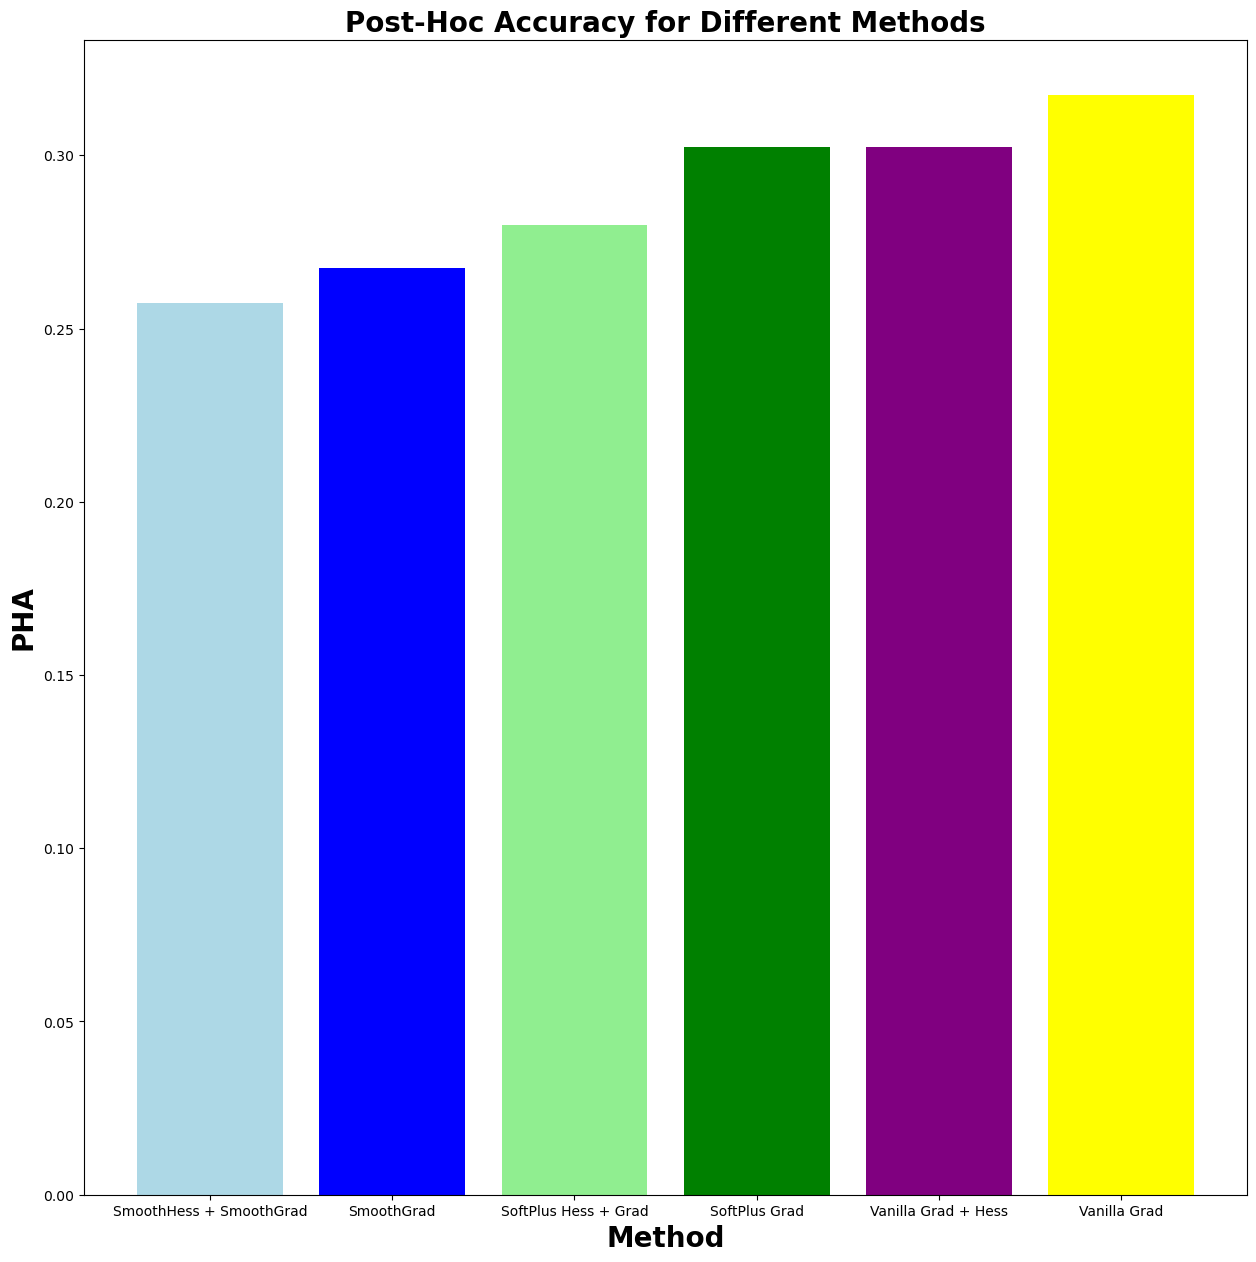

In [19]:
fig = plt.figure(figsize  = (15,15))
methods = ["SmoothHess + SmoothGrad", "SmoothGrad", "SoftPlus Hess + Grad", "SoftPlus Grad", "Vanilla Grad + Hess", "Vanilla Grad"] # , "Vanilla Grad", "Vanilla Grad + Hess"]
values  = [SmoothHess_PHA, SmoothGrad_PHA, SoftPlusHessGrad_PHA, SoftPlusGrad_PHA, VanillaHessGrad_PHA, VanillaGrad_PHA] #, VanillaGrad_PHA, VanillaGradHess_PHA]
values = [float(val) for val in values]
plt.bar(methods, values, color=['lightblue', 'blue', 'lightgreen', 'green', 'purple', "yellow", "orange"])
plt.title("Post-Hoc Accuracy for Different Methods", weight='bold', size = 20)
plt.ylabel("PHA", weight='bold', size = 20)
plt.xlabel("Method", weight = "bold", size = 20) 
